In [372]:
import math
import numpy as np
import scipy
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from scipy.stats import linregress
from scipy.fft import fft2, fftfreq
from scipy.io import savemat

In [416]:
e = 8.5424546e-2
c = 1
m = 510.99906 # m_e
E = np.array([0, 0, 0]) # 0 Tesla
B = np.array([692.5, 0, 0]) # 1 Tesla
t_span = (0, 1519267) # 1 ns
p0 = np.array([0.577, 0.577, 0.577])*m # c/2*m_e
r0 = np.array([0, 0, 0])
rtol = 1e-5
p_atol = 1e-2
r_atol = 1
atol = np.array([p_atol, p_atol, p_atol, r_atol, r_atol, r_atol])
t_eval = np.linspace(*t_span, 10000)

In [648]:
def gamma(v):
    v2 = np.dot(v, v)
    if v2 > c**2:
        return 1000
    return 1 / math.sqrt(1 - v2/c**2)
def lorentz(v):
    return e * (E + np.cross(v, B) / c)
def g0(v, l, gv):
    return v * gv**2 / m**2 / c**6 * np.dot(v, v) * [np.dot(l, l) - e**2 * np.dot(v, E)**2]
def fun(t, y):
    p, r = np.split(y, 2)
    v = p / m
    gv = gamma(v)
    if t % 1 < 0.01:
        print(t, np.dot(v,v), gv)
    l = lorentz(v)
    g = g0(v, l, gv)
    dpdt = l - 2/3 * e**2 / c * g
    drdt = v / gv
    return np.concatenate([dpdt, drdt])
def plot3D(ax, u, c, prefix, suffix):
    x, y, z = u
    sc = ax.scatter(x, y, z, c=c, cmap="hot", marker=".", s=1)
    plt.colorbar(sc, ax=ax, location="bottom", shrink=0.5, pad=0.01, label="t (s)")
    ax.set_xlabel(prefix + "x" + suffix)
    ax.set_ylabel(prefix + "y" + suffix)
    ax.set_zlabel(prefix + "z" + suffix)
    return ax

In [418]:
np.divide(fun(0, np.concatenate([np.array([0.5, 0.5, 0.5])*m, r0]))[:3], p0)

0 0.75 2.0


array([-1.65845679e-07,  1.00317299e-01, -1.00317630e-01])

In [419]:
%%time
y0 = np.concatenate([p0, r0])
sol = solve_ivp(fun, t_span, y0, method="RK45", t_eval=t_eval, dense_output=True, rtol=rtol, atol=atol)

0.0 0.9987869999999999 28.71240687100917
7.0068275624708445 0.9981340215024617 23.149770108333076
7.0068275624708445 0.9980417687478428 22.597896297593007
17.009260816282204 0.9973307242464933 19.35545028648886
38.00042513834076 1.0042618732609137 1000
38.00042513834076 0.9962042520849819 16.231225780055745
38.00042513834076 0.9962203341803028 16.265720237430262
61.00724296048031 38946526511.85623 1000
61.00724296048031 2.5456147953341615e+50 1000
63.005570598548715 0.995543905586442 14.980379241788217
87.00102119561798 0.9944569286251296 13.431507675847115
96.0052957682848 0.9941821768038779 13.110514662396275
104.0052149945573 0.9942797943985513 13.221909509632011
111.00727219967942 0.815639223442304 2.328979874211924
120.00988719272655 1.0016301796014653 1000
120.00988719272655 0.9934920861749965 12.395929660688472
120.00988719272655 0.9935383319426881 12.44020903537229
126.00510639568824 0.9937165583794537 12.615405299209062
131.00235221907772 274.4958238928846 1000
138.00557472387

C:\Users\johan\AppData\Local\Temp/ipykernel_16832/226573285.py:9: RuntimeWarning: overflow encountered in multiply
  return v * gv**2 / m**2 / c**6 * np.dot(v, v) * [np.dot(l, l) - e**2 * np.dot(v, E)**2]


636.006046924316 0.9506659450628178 4.502218761814505
636.006046924316 0.9855756938480538 8.326309194183318
729.0049218761013 0.9925231825356549 11.564892786292814
834.0018569056723 0.9498801955029594 4.466787744190521
836.0016131845217 0.9835386063866675 7.794113040387842
926.0051367292275 0.9506653512340549 4.502191665695354
975.0022576806525 0.9466808714646946 4.330703777070112
975.0022576806525 0.9820413391113562 7.4621336831359395
1068.0092668755633 0.9891580730868242 9.603880827257651
1083.0042555479044 0.9811440083657358 7.282413110498003
1159.0066691052505 0.9447052742252067 4.252635357537212
1159.0066691052505 0.9803410220795744 7.132134629836468
1252.0007599486612 0.9879299037892064 9.102163535498109
1285.0032292240671 0.9425751802537358 4.173017247326155
1285.0032292240671 0.9792414621789343 6.940673582722804
1330.004678393976 0.9789835348657607 6.897951939827905
1376.0055341959512 0.9688645030101413 5.667246446167674
1469.0023361817136 0.9434891988490093 4.206629545934723
1

13748.008013458073 0.9314449229981979 3.8192684784063338
13841.006846304283 0.9233826290801328 3.612737252689927
13859.007909429754 0.8892006583557368 3.004217765932619
13859.007909429754 0.9232002526089842 3.6084451168518608
14136.008354670166 0.8909415750265677 3.028101228146092
14209.008300203841 0.8918643273044595 3.0409936050879396
14303.00979038633 0.9296058076125866 3.769047273257814
14321.005430006313 0.8896048153293112 3.009711965333911
14342.00131302194 0.929349385739836 3.762201298193329
14380.001500559683 0.8871878855176738 2.9772967974680835
14380.001500559683 0.9215689652488344 3.570721903691205
14435.002795889517 0.9215166785412383 3.5695322726030807
14508.005506148207 0.92130264159555 3.564674854335906
14618.005179679578 0.8894850597166224 3.0080808392878593
14678.007414279671 0.9280853653497589 3.728991219791968
14715.00361047592 0.9112162860394225 3.356088045712616
14750.007163215141 0.889084660960171 3.002646420619155
14750.007163215141 0.9204252514937498 3.544968354

25092.002968224544 0.8920976079367371 3.044279083218146
25114.008893949267 0.883593754639739 2.9309732802008495
25286.004411404527 0.8575586346978772 2.6496098897796627
25286.004411404527 0.8914851170257286 3.0356755085196427
25390.008978540973 0.8913533416589373 3.0338339948017325
25413.00366808448 0.8593941595489809 2.6668483461405166
25413.00366808448 0.8911689793430204 3.031263212426662
25434.00315163509 0.8912447643646179 3.032319181550016
25476.007248062022 0.8593988989873461 2.6668932933591494
25478.00674617672 0.8911244641536323 3.03064346323106
25541.007267213194 0.898486662042547 3.138617889193507
25605.000521198617 0.8908142727929539 3.0263354457191283
25628.00238471742 0.8571223966035018 2.645561864168436
25628.00238471742 0.8906347848680768 3.0238510464525628
25818.007510613217 0.8593844872572087 2.6667566244719754
25820.00360767988 0.8902766357204241 3.0189119212411364
25945.007724211697 0.8609307428740914 2.6815409446080976
26186.001131599387 0.8965380655499491 3.1089211

34757.00988807387 0.8693227215521605 2.7663043487434753
34778.00283388699 0.869398007431724 2.767101555765543
34876.00618263187 0.8691861889783677 2.7648603526865543
35046.00630814218 0.8370109974184423 2.476970583646977
35046.00630814218 0.8686855476892494 2.759584752478158
35192.0087725047 0.8595350425323639 2.6681854034297525
35214.0078757026 0.8684408043165326 2.757016689939676
35312.00500846501 0.8682255779931254 2.7547642609524456
35335.00560715984 0.8375673477312646 2.4812089105794004
35335.00560715984 0.8680504519662586 2.752935565415309
35433.00796787048 0.8356734004426023 2.466868877102123
35433.00796787048 0.8678353617781003 2.7506945327649426
35653.00334613441 0.8365310830466725 2.473331948357257
35677.008582535105 0.8586171421832752 2.659509965585562
35874.005783747125 0.8355611488857622 2.4660267490306214
35874.005783747125 0.8668704950815782 2.7407084672402204
36069.00540384155 0.8579893707891945 2.653625147335881
36119.0005214786 0.8358469567134519 2.468172622216236
361

46782.00998264928 0.8154476835205502 2.327770980069643
46929.00286244234 0.8354033746868994 2.4648445599189324
46954.005634946014 0.8140860301137073 2.319230894860611
47157.00696804614 0.8506584584511387 2.5876747317970468
47216.006983947234 0.8502063905385502 2.583767059591611
47329.00128250654 0.8502625146342069 2.584251233623287
47388.00948244339 0.8501804149421351 2.583543064178469
47416.00869187548 0.81307157562196 2.3129291379773393
47447.00918544678 0.8497652735252877 2.5799710615217943
47560.003311027416 0.8498234219646292 2.580470496165561
47735.00326094339 0.8345707183876533 2.4586335753847735
47794.0043609931 0.8337905436568325 2.45285646721724
47853.00733843085 0.8338009459403063 2.452933227308334
47967.0054899428 0.8124364501198411 2.3090098104509575
47967.0054899428 0.841934153594185 2.5152489674739202
48143.00820860529 0.8336556944013841 2.451862045047891
48204.00170129748 0.848397904711451 2.5683097362331297
48438.00178829484 0.8330436221702093 2.4473635806926937
48701.

61446.00678097068 0.8169114285485972 2.3370574150857975
61557.00786637387 0.8084562391240795 2.284893671657467
61705.00694957753 0.8080340146926042 2.282379504906933
61706.003900903 0.7852933070727637 2.1581280460522483
61706.003900903 0.8163325120032379 2.3333713271707532
61809.000468066675 0.7882929127516898 2.173363161527414
61854.00993569091 0.7848662627265921 2.155985020502553
61854.00993569091 0.8160691076804115 2.3316999377400585
61957.00622572958 0.7886528999989121 2.175213317378047
61964.0046427108 0.8159807672946875 2.3311401919028607
61997.00451298892 0.7871171427028101 2.167353017006451
61997.00451298892 0.8158152689215241 2.3300926386915455
61998.00138845579 0.8226848275301915 2.374800056530603
62105.00062192127 0.7889724174465214 2.176859442769208
62112.00411522339 0.8157226797310151 2.3295071936208758
62145.00424182927 0.7873667631860166 2.1686248243388024
62145.00424182927 0.8155524249491335 2.3284318167714044
62223.00721281013 0.8075221991353837 2.2793429601065918
6225

73997.00198581912 0.7870850902978543 2.1671898732149852
73998.00327391223 0.7648357400831862 2.062121929098379
73998.00327391223 0.7952116472245776 2.20977152829585
74225.00047501278 0.7673359677737911 2.0731721914169263
74232.00560334048 0.7949285546008737 2.208245752581382
74374.00924838675 0.7654058523375439 2.064626099806438
74374.00924838675 0.7945879506353085 2.2064141917979683
74375.00909578639 0.8012405982136293 2.2430355640617496
74378.00863798527 0.7865075063627063 2.1642563232027667
74379.00848538491 0.7644012696279499 2.060219659755761
74379.00848538491 0.7945794084863536 2.2063683158843483
74666.00470944462 0.7650686535784326 2.063143880936097
74666.00470944462 0.7941040793492243 2.2038200450684675
74712.00288087796 0.7941425221089902 2.2040258111414426
74811.00654483716 0.7939763981641914 2.2031370408820643
74953.00076551255 0.7663808083389856 2.0689297356697542
74953.00076551255 0.7936295480239505 2.2012848383556958
75052.00849767581 0.7645377554873019 2.0608166771565406

84999.00047927992 0.7775404125933604 2.1201883132691615
85116.00756167553 0.7522311716355242 2.0089848718442633
85128.00559919603 0.777328331824703 2.1191783996865348
85257.00343049914 0.7771342346633814 2.11825538643744
85319.00392906235 0.7697566038664436 2.0840417197669296
85379.00457692074 0.749704082469946 1.998817379650565
85520.00017910745 0.7767096600778244 2.11624055379847
85578.00630440489 0.74957940080234 1.9983197230817336
85578.00630440489 0.7765173619429225 2.1153298864336594
85579.00563945332 0.7829416744919777 2.146405516421803
85582.00364459863 0.76872194059818 2.0793748299231765
85583.00297964706 0.7473928617306007 1.9896523105234742
85583.00297964706 0.7765093494442382 2.1152919671072685
85642.00860238478 0.7497952460445808 1.9991814869253905
85712.00619475148 0.7490113138047224 1.996056946699253
85712.00619475148 0.7763069066203703 2.1143345781176133
85771.00145381586 0.7497208338813663 1.9988842698607183
85776.00876814398 0.7488186741319662 1.9952913772259733
85847

98280.00169118909 0.7497851335381442 1.9991410877672378
98282.00183314644 0.763389694833245 2.0558109368499227
98287.00800490096 0.7630526800953312 2.0543484068682902
98387.00504605852 0.7570634912709978 2.028867134316237
98392.00424180811 0.7570588979134812 2.028847954037411
98728.00163786228 0.7490955856235363 1.9963921285806974
98730.00274111291 0.762713128967297 2.0528780220116016
98735.00880942441 0.7623888655285658 2.0514767818061705
98845.00740225171 0.7563773650843156 2.0260081216799275
98964.0083131867 0.7621549650483708 2.0504678067115765
99072.00067189493 0.7291600175665198 1.9215142587152163
99186.0074000499 0.7487961796609012 1.9952020393550023
99196.0014701774 0.7482349696908689 1.9929770441513286
99197.00232584575 0.7276430885618377 1.9161557190078422
99197.00232584575 0.7557556534864847 2.023427928230842
99308.00827125715 0.7556939468699199 2.0231723742343317
99525.00572993842 0.7311610255508638 1.9286520578836788
99535.00826102657 0.7288309188607394 1.9203479018530003


111617.00771307353 0.713485759684604 1.8682151686617052
111652.00119810268 0.7121226807355145 1.863786986655062
112078.00273853281 0.7431520728912967 1.9731584762008356
112091.00038376263 0.7302019818375927 1.9252211425876304
112102.00897193443 0.7106560055042913 1.8590572477219225
112102.00897193443 0.7371168939762818 1.9503774241590708
112103.00460239947 0.7430084004991229 1.9726068472148448
112521.00532883001 0.7112492999477493 1.8609661649133702
112531.00461883872 0.7105417998856383 1.8586904663881854
112546.00147573021 0.7104960033512113 1.8585434477813216
112558.00642802866 0.736579843562768 1.9483882342723136
112563.00995192243 0.7365654997678978 1.9483351894707168
112573.00591619992 0.7365553705537081 1.9482977332238542
113041.00154389012 0.710178367574869 1.85752471477071
113041.00154389012 0.7357962055913748 1.9454965936585185
113042.00863602283 0.7418073724714198 1.9680135369870793
113056.0026609579 0.7096247799271511 1.8557532252674946
113056.0026609579 0.735775078749768 1.

125022.00054234748 0.6958894605180717 1.8133609710578538
125218.00104689397 0.6919124456101764 1.8016188727407492
125218.00104689397 0.7190637062815923 1.8866705730173714
125242.00581469448 0.7119245734914916 1.8631460204872992
125465.00724639551 0.7188250414690157 1.8858696882713593
125475.00250342765 0.7188208647462222 1.8858556815703345
125485.0074127479 0.7188078029415643 1.8858118806312503
125508.0075991793 0.6953933012713583 1.8118835208050297
125693.00731914323 0.711134910090151 1.8605976594401101
125695.00729792316 0.7239831503584953 1.9034093689294715
125926.00542990527 0.7182065359581286 1.8837989135932842
125936.00235729036 0.7182021978771128 1.88378441365096
125946.00528618123 0.7181883283640764 1.8837380573488867
125954.00319238368 0.6935976497856217 1.8065665052829787
126164.00009668144 0.7107736876274298 1.8594354213954656
126165.00378056799 0.6915681294302906 1.8006129783953746
126165.00378056799 0.7177922427176006 1.8824156564386652
126175.00897050969 0.692908875976910

137607.0043069847 0.6762182799355605 1.7574130097074303
137607.0043069847 0.7027416070912107 1.834141921287681
137618.00949033824 0.7083901559957735 1.851820594691505
137714.00550732884 0.7027033271748141 1.8340238354393432
137910.0087403377 0.7024454581829981 1.8332289553071057
137923.00819068452 0.6795011862184601 1.7663907702101889
138008.00319381853 0.6955134285348049 1.8122409013366818
138009.0043203162 0.6771431110655631 1.7599282851197833
138009.0043203162 0.7022232551289224 1.8325448436366303
138201.00508439323 0.7076432854478218 1.8494537006878533
138297.00543264128 0.7019522832229247 1.831711619530253
138392.0060390416 0.7073568434609612 1.8485483473964226
138687.00028222174 0.6780025084070034 1.7622753062751828
138865.0083631032 0.7012222802877589 1.8294725425567062
138868.00047607537 0.6764920851180178 1.7581565572306774
138878.00777531057 0.6773705187301728 1.7605484247917502
138958.00365076071 0.6942805394194136 1.8085830556528375
138959.00589065594 0.6758868953468335 1.7

149030.00886053615 0.6642304631250701 1.7257558497091772
149085.00524930924 0.6812465353210716 1.7712201448959743
149092.00010191294 0.6936236441943129 1.8066431424501894
149217.00171163733 0.6633468161181094 1.7234894802559366
149217.00171163733 0.6880277824953414 1.7903668997899505
149279.00437726782 0.6880412255346984 1.790405474940558
149287.00836493916 0.664083374005429 1.7253779766261614
149468.00195530156 0.6810452658474504 1.7706612116602707
149721.0068680145 0.6620215316506755 1.720107079340984
149721.0068680145 0.6874009877736775 1.788571059795838
149783.00837602004 0.6874173043879507 1.788617740312168
149912.0075120329 0.663170885542784 1.723039320090955
149972.00613487154 0.6808179445548531 1.7700305673606862
149974.00995773778 0.6925177260979081 1.8033912490918627
150093.00439681375 0.6804319762081898 1.768961339329125
150094.00680483444 0.6626250545281216 1.7216449234122155
150094.00680483444 0.6869377619085469 1.787247330866072
150156.0029811611 0.6869584257603999 1.7873

160841.00613008306 0.6790410507779255 1.7651241432604332
160890.00723251517 0.650237852421738 1.6908831508911164
160895.0026736472 0.6523452264774618 1.6960002094249977
160931.0005917632 0.6484584085992618 1.6865982399917463
160931.0005917632 0.6737049528614546 1.7506315826178476
160937.0064540264 0.6789690936660648 1.7649263112900122
161451.00521820536 0.6514809632912874 1.6938960196368262
161487.0012323204 0.6478356792143001 1.6851063810208218
161487.0012323204 0.6730375331263649 1.7488439111663812
161488.00260203122 0.6781850016291305 1.7627749065426888
161491.00671116365 0.6667680130789349 1.7323141733283622
161492.00808087445 0.6496200747578617 1.6893918401452357
161492.00808087445 0.6730317244905142 1.7488283768725101
161630.0037852795 0.672960112269587 1.7486368951215385
161675.00772696835 0.6781400655615564 1.7626518484531095
161855.00468941036 0.6659546780127453 1.730203964853194
161906.0014025773 0.6492295838207695 1.688451230742046
161947.00114646938 0.6475247413267058 1.684

172982.00358701183 0.6530962169469644 1.6978349997518578
173091.0068108017 0.6594381008705505 1.7135704745537004
173201.0075184929 0.6359597726785751 1.657392279821249
173201.0075184929 0.6592246376840549 1.7130336964376784
173241.00644399365 0.637439571920203 1.6607711791005326
173638.0048474284 0.6638606297564693 1.7248062171950782
173780.0075244507 0.6636239417704621 1.7241992882254793
173996.00985581867 0.6517152823541261 1.6944657336833424
174247.0002531656 0.6581027954917374 1.7102209613949062
174397.0076374094 0.6367700260978724 1.659239814151723
174428.00811066464 0.6340897749609324 1.653151772838969
174428.00811066464 0.6578046528021579 1.7094757715610298
174640.00057608428 0.6515529721089866 1.6940710378444945
174641.00122179292 0.6351090687736777 1.655459136641051
174641.00122179292 0.6575586465859662 1.7088616266609713
174676.00297218945 0.6346975470169236 1.6545264171673122
174924.00059441253 0.6511733114327982 1.6931488789641471
174925.00368077317 0.6345956410027365 1.654

186542.00079674696 0.6490352428568242 1.687983689955497
186749.0091279656 0.6218805606657104 1.6262432140866223
186775.00058015 0.6207747199349118 1.6238703779042398
186775.00058015 0.643784168520272 1.6754959848738797
186891.0016135405 0.6376662596900191 1.6612906140955577
187036.0027854174 0.6435819332251584 1.6750205705554815
187039.00827198842 0.621797577478022 1.6260647934298678
187064.00425619236 0.6370668471027988 1.6599181712684192
187156.00692390953 0.6214594443786314 1.6253383862340716
187182.0020666784 0.6203577015416801 1.6229782619782143
187182.0020666784 0.6433300333966027 1.6744289705341764
187239.0009987636 0.6482205758941963 1.686028001915865
187273.007753471 0.6227956186479078 1.628214566360214
187326.00664569798 0.6432548847568268 1.6742526013542476
187644.00516400966 0.636509833700403 1.6586458519055363
187700.00312151352 0.6363537752064219 1.6582899104260538
187757.0085225616 0.6189179235698068 1.6199094484722156
187757.0085225616 0.6426891256980041 1.6729265868174

198420.00406645148 0.609271531210079 1.5997881380058332
198519.009199527 0.6309673575690722 1.6461431855719044
198595.0013679682 0.6356489393270038 1.6566851558752456
198646.00540752106 0.6356112816726998 1.6565995488220153
198695.0046441755 0.6247530928179561 1.6324558301964687
198772.00527168877 0.6089706518714864 1.599172537376708
198823.00107902824 0.6097279023719114 1.600723234138187
198844.00674993495 0.6077597131259777 1.5967021168573114
198844.00674993495 0.6305337022672837 1.645176834490002
198993.0088353605 0.6350436129019202 1.6553106745455044
199022.0062446998 0.6102597399057003 1.6018150311039299
199043.00497324302 0.6072801143403962 1.5957268538733533
199043.00497324302 0.6303188331028315 1.6446986533110246
199094.00882947983 0.6082059943026141 1.597611236554552
199094.00882947983 0.6302638701184751 1.6445764027398742
199144.00891330838 0.6244926492714957 1.631889614473346
199218.00570891332 0.6302193505636997 1.6444774007867118
199269.00038101475 0.6301622764195103 1.644

211589.00061324408 0.5972489696164817 1.5757295151752793
211692.00271888747 0.5943485871234446 1.5700862255372874
211692.00271888747 0.61689432711629 1.6156255348651183
211737.00480120332 0.6112145207136228 1.6037806966399728
211865.00169192124 0.6106456960331634 1.6026087518709318
211888.00527851362 0.6167753444621875 1.6153747076615477
211995.00958283668 0.6212119692827185 1.6248073550772903
212208.00491902774 0.6104187562006629 1.6021419060612647
212251.00868435827 0.6208787262310429 1.624093105001572
212337.00014683194 0.594707657206409 1.5707815830833645
212337.00014683194 0.6162219593085037 1.6142096503040992
212464.00410375523 0.610021446846131 1.6013255686345138
212551.00923860757 0.6103816323392885 1.6020655760986335
212743.00585044673 0.6158846122564837 1.6135006595965116
212762.00133768708 0.5932043683078928 1.5678765320968222
212762.00133768708 0.6157793094716658 1.6132795395995627
212787.00779702244 0.5949622753524516 1.5712752243358352
212912.0097770472 0.6157059960751583

225121.00083119873 0.5828165821136376 1.548233574061098
225475.00838275198 0.596851771635577 1.5749530875816933
225609.00138403708 0.5824441644666614 1.5475429860273369
225738.00574468248 0.5815952441495438 1.545972248938535
225738.00574468248 0.6025034326432934 1.586110019941542
225850.00261687854 0.5967869377682489 1.5748264617179992
225887.00105947696 0.5813188919919823 1.5454619521030601
225887.00105947696 0.6023535640114182 1.5858110979359568
225924.00388165234 0.6067348725628654 1.5946202737737913
226036.00383537955 0.5810535236930865 1.544972412750378
226036.00383537955 0.6022037399193967 1.5855124336354445
226185.00706430356 0.5807959108969298 1.544497625124657
226185.00706430356 0.6020539909793436 1.5852140877020882
226371.00803832297 0.6063227249403034 1.5937853372661783
226652.00086549952 0.581900491568593 1.5465364901401182
226668.00258918563 0.5799357278657071 1.5429154488168888
226668.00258918563 0.601569044703911 1.5842490801932414
226798.0030934489 0.601519345371519 1.5

236584.00061858687 0.5961645505386118 1.5736124402379827
236685.00193891712 0.5859604086841639 1.554100371937097
236770.00713839437 0.5916410982470098 1.5648726001865627
236855.0020040083 0.5859239856282061 1.5540320193548673
237058.0023736699 0.5956827750782107 1.5726746198980432
237211.0071294706 0.5712569100449247 1.5272194035779465
237293.00891632686 0.5852845712686201 1.5528335424849111
237428.00003543665 0.5697364150700377 1.5245185189712742
237428.00003543665 0.5909201793632779 1.5634931094112707
237496.00951578942 0.5952297927519601 1.5717943757269894
237512.00144744848 0.5909159912870359 1.5634851061100346
237563.0037969866 0.595186523306986 1.5717103710042784
237597.0041138036 0.5854631384332937 1.553167958135224
237664.00837840213 0.5852657407872444 1.5527982898690884
237984.00248419907 0.5706023068836525 1.5260548608153348
238133.0045673759 0.5845153839563322 1.551395495042281
238233.00732480266 0.5943686739724362 1.5701251003633439
238366.00212378905 0.568630076202782 1.52

250303.00823767277 0.5786384902803383 1.540538545899346
250487.0087174126 0.5602505902838278 1.5079862007401865
250515.0029640738 0.578434267236367 1.5401653519241656
250741.00893036654 0.5573391311436664 1.503018873004724
250741.00893036654 0.5781446868030647 1.539636641841346
250983.0045559276 0.5723284095902883 1.5291313743940411
251089.0012927461 0.5778965772703073 1.5391840813339077
251104.00398509338 0.5820525389439504 1.5468177760117696
251164.00364811334 0.5723891027768473 1.5292398895925923
251315.00594782908 0.5580397659522405 1.5042097610481258
251315.00594782908 0.5776036867566707 1.538650352016549
251345.00847609068 0.5722661263427521 1.5290200402900298
251434.00274292892 0.556813590391896 1.5021274512914047
251434.00274292892 0.5774914649796525 1.5384459992880544
251585.00649003024 0.5814561521692491 1.545715346094607
251616.00912054826 0.5815371631133519 1.5458649577072379
251735.00423898516 0.5813331412826261 1.545488251711809
251885.00533130273 0.5812120886141476 1.545

262658.00250790257 0.5494450274857575 1.4897936075049174
262741.0008825429 0.5494194898432675 1.4897513882402438
262809.0070897609 0.5481386629818068 1.4876384970470151
262809.0070897609 0.5669315558260235 1.519573566121433
262824.00826394936 0.5490327224543302 1.4891124163274851
263057.00622773304 0.5613527378304244 1.5098794994587528
263167.00523913646 0.5466442436413035 1.4851845844063967
263167.00523913646 0.5666040226291782 1.5189992589242527
263277.00812822825 0.5705575114460923 1.5259752668303155
263359.0054021213 0.5462009247919124 1.484458964592648
263359.0054021213 0.5664284317304629 1.5186916402116775
263552.00513350626 0.5702255908511222 1.525385887332396
263623.0041050425 0.548636297492722 1.4884583417935693
263690.00012026535 0.561084398272699 1.5094178818492274
263786.00120894634 0.5661138677227047 1.5181410206924162
263800.0005525129 0.5471884307608528 1.4860767608582595
263800.0005525129 0.5660258456518803 1.5179870521994052
263815.0072635396 0.5480499203830289 1.48749

276368.00089415506 0.5367517964066977 1.4692413010645688
276493.00317222177 0.5362882778100594 1.4685068027731043
276681.003294599 0.5351163837521309 1.4666547044711908
276681.003294599 0.5544564060866441 1.498148618533989
276719.00628932734 0.5544981338752456 1.4982187786947214
276781.00340711995 0.5582022395595522 1.5044863264165944
276932.009575581 0.55810849252152 1.5043267299820424
277083.0000467179 0.5580206631860622 1.5041772540105276
277097.00446807675 0.5369344603511841 1.469531055891054
277208.0032394398 0.5579619534808762 1.5040773613245264
277222.0029203884 0.5362087371101172 1.4683808721262488
277321.0004846244 0.5355942237388088 1.4674090513355593
277333.00315131556 0.5578179806950485 1.5038324804520788
277396.0024481659 0.5538991937844522 1.4972126779692105
277583.0064210659 0.5575199638211199 1.5033259684002707
277858.0015627284 0.5349231389788127 1.4663499668813527
277858.0015627284 0.5534178486862787 1.4964055809101147
277932.00264467485 0.5572020809667078 1.502786255

289581.0025162935 0.5252306446287587 1.4513048963496087
289581.0025162935 0.543238769571543 1.4796376817353827
289708.00784209813 0.5432024256946835 1.479578818857819
289905.00466974743 0.5252395532361712 1.4513185127376147
289905.00466974743 0.5429616497040806 1.4791890332006081
290089.00488649413 0.5465455201937801 1.485022902771051
290136.00582959957 0.5465538463401887 1.4850365366515572
290147.008362598 0.5428237070942422 1.4789658604415126
290218.0026421746 0.525954480075437 1.4524124959120677
290228.0059431582 0.5378138939864032 1.4709284809136587
290424.000175904 0.5425916817817181 1.478590702151925
290563.009961376 0.5246455665330737 1.4504114702156368
290574.0099546276 0.5238664180426662 1.449224252332664
290574.0099546276 0.5423901415641192 1.4782650663463073
290804.00771837385 0.5238321605135732 1.449172119732714
290804.00771837385 0.5421938879052971 1.4779481788924174
290840.0081905425 0.5257354054723069 1.4520770044502664
290999.0091366527 0.5420966951453389 1.477791318825

303759.0080315021 0.5151100395458417 1.4360792393712913
303811.00584043487 0.5266678955350337 1.45350663613328
303992.00840595097 0.5311990617032303 1.4605141329936944
304142.00100448646 0.5142067998471427 1.4347435606516787
304194.00956522906 0.526216132207084 1.4528134956056462
304215.0098161843 0.5260288267988961 1.4525264035525778
304279.00761859457 0.5127431090256587 1.4325869975761538
304279.00761859457 0.5308910620727894 1.4600345944070037
304321.00236728 0.5125028041971118 1.4322338673320452
304321.00236728 0.5308563721696266 1.4599806137153781
304343.0082272575 0.5345038292103583 1.4656893885260853
304406.0077211913 0.5343449957709624 1.4654393962143806
304588.00360666885 0.5142148905416736 1.4347555083455468
304640.0038788505 0.5259441734684095 1.452396707132177
304703.002171196 0.5256049682653856 1.451877362930794
304831.00704938784 0.5340873502673565 1.4650341527816777
304989.0055270172 0.5303717111694689 1.459227062090649
305160.00423731486 0.5133324262646962 1.43345411183

317322.0053391908 0.5203722662622161 1.4439357071508512
317352.00872575154 0.5031206030344244 1.418647527302266
317352.00872575154 0.5202834337801168 1.4438020091085797
317451.0098029836 0.5155565710745779 1.4367409337201005
317462.0021255665 0.5046135486241978 1.4207836073639488
317609.0082595013 0.5154802406385878 1.4366277583755573
317648.0072473127 0.5234706167765194 1.4486222706170417
317778.0038377557 0.503701339506225 1.419477289257336
317846.00297694077 0.515158405673396 1.436150866744392
317857.00144524674 0.5040951067598716 1.4200407367750394
317936.0063885833 0.5042669029105213 1.420286772798845
318407.00210994825 0.5195079716035047 1.4426364684947925
318486.00862239656 0.5194480453507548 1.4425465151690724
318496.0064532336 0.5229145938599807 1.4477778704416595
318515.00644739834 0.5145462556530507 1.4352450985708103
318605.00250850234 0.5032048981098511 1.4187678786579503
318702.00758703804 0.5192766944747419 1.4422893988229941
318731.00483740104 0.5143624007560079 1.43497

331541.00632808486 0.4930118943683636 1.4044332884203974
331605.0086070679 0.49220185995238264 1.4033126725115481
331605.0086070679 0.509107197273951 1.4272717426682173
331678.00409173337 0.5044649073111582 1.4205705013867698
331733.0025179422 0.5123167603938588 1.4319606534593068
331770.0083519887 0.5123587437178305 1.4320222942386094
331807.0038978593 0.5123692292872084 1.4320376906094898
331871.0073503028 0.5089663721330998 1.4270670620252732
331954.0061549067 0.49261014032417527 1.403877159362706
331954.0061549067 0.5088385426871979 1.4268813460454817
332045.00340964773 0.5120726940445457 1.431602467802567
332165.0028680031 0.49254426516080296 1.403786034529142
332384.0065622432 0.5085699943875787 1.4264914238607487
332421.00771408394 0.5085455437074162 1.4264559382537494
332540.00070133957 0.5038418812543569 1.4196783155903063
332558.00825391855 0.5117106108669272 1.4310715784231869
332796.0039294433 0.511580915353196 1.4308815613943886
332832.000836209 0.4911387546797983 1.401846

343438.0083377528 0.48345448885248354 1.3913798323412767
343438.0083377528 0.5001276443603356 1.4143941133288445
343455.0028294401 0.5033040701642545 1.4189095096782864
343620.00428915553 0.5000531569807993 1.4142887436909473
343767.00975048327 0.4831078189819167 1.390913167931448
343767.00975048327 0.49988172890858124 1.4140463314588634
343846.00773559336 0.48411891563166337 1.3922755547988157
343880.0034040649 0.49986054998365204 1.4140163915109643
343915.00499421166 0.4840635265772599 1.392200817985004
344148.00912272267 0.49518868815158074 1.4074580552729217
344769.00290287164 0.4945917535994794 1.4066266397059357
344830.0081638572 0.4991520080407488 1.413015843911841
344899.00824746833 0.49910149212176047 1.412944590361928
345114.0049386188 0.49463742647720266 1.40669020123423
345200.00187863474 0.4825319150459017 1.3901389604121779
345200.00187863474 0.498813326847339 1.4125383344394555
345423.00023126125 0.4820256067723412 1.389459379580557
345423.00023126125 0.4986473202708319 

358385.0003365435 0.47485323808469354 1.3799382537042415
358643.00254387123 0.4890373962066027 1.398960466560413
358877.00375856477 0.49197482995147346 1.4029990761604523
358909.00185655506 0.4918393049932952 1.4028119758276076
359224.00854074245 0.48861785482302045 1.3983864904807644
359248.00456611573 0.4841829958916709 1.3923620337323646
359425.0002983457 0.4722581845152407 1.3765413021522903
359425.0002983457 0.488413753766462 1.3981075144187805
359522.00549690257 0.49142053992258916 1.4022343181765429
359547.009807334 0.47329560633666135 1.377896285614698
360053.0062604121 0.4838550818580575 1.3919196699941558
360069.0078239514 0.4837441545436303 1.3917701218513288
360085.00575278077 0.4836170181767212 1.391598780525587
360117.0059123793 0.48359869478871237 1.3915740913639334
360197.00147393654 0.48348722570447317 1.3914239248363571
360310.00970227836 0.47236619399845853 1.3766821876536424
360310.00970227836 0.48777915518137954 1.3972411771417839
360342.0086254675 0.47209601883842

372537.00939563743 0.47512291533171475 1.3802927082729
372591.0060185709 0.46527660625406564 1.367525419459738
372719.00633825053 0.47477915649220137 1.379840931187752
372727.005291085 0.4790826978666311 1.3855289630000485
372773.0033581814 0.464384380635429 1.3663859364806448
372780.0071199476 0.4819775744651756 1.3893949610500596
372886.0016831702 0.46344175208763383 1.3651851716219896
372886.0016831702 0.4789126828575232 1.385302916492361
373046.00504978537 0.46413591179802693 1.3660691176296291
373182.00477002934 0.4787662523795281 1.3851083158761426
373417.00903550256 0.48151783265982434 1.3887788312680696
373592.0080870435 0.4642256656742101 1.3661835360107037
373705.00068436307 0.46345767139959004 1.3652054241223657
373705.00068436307 0.47834515622209045 1.3845491515636195
373780.0074493055 0.46265688548951117 1.3641877830223752
373780.0074493055 0.47829310498677485 1.3844800808919124
373803.00662607275 0.4783381904871592 1.3845399076105365
373856.00256303657 0.4812735976844866 

385698.0012550369 0.4558543663095577 1.35563391581638
385698.0012550369 0.4701683763584843 1.3738238827298463
385748.0061460308 0.47019003234778417 1.3738519599774481
385778.00083292904 0.4567745109753577 1.3567815530028593
385950.00909118936 0.45579770176712386 1.3555633369383515
386043.0025542462 0.4728411482963748 1.3773022226855662
386086.006543389 0.4727499764313886 1.3771831362601714
386452.0020602018 0.46971956239076035 1.3732423773361748
386488.0003906902 0.4549639766003451 1.35452615797476
386488.0003906902 0.469638537251167 1.3731374758556512
386538.0007163163 0.46966169171248884 1.3731674509781837
386617.0095455665 0.454551556313327 1.3540139741828927
386617.0095455665 0.46955208631129564 1.3730255762144155
386753.00633433426 0.46951652526506515 1.372979554946447
386796.0008932035 0.4694890163586599 1.3729439575159812
386968.0077068444 0.46937350352886553 1.37279451032974
387433.0079857888 0.4651680959695293 1.3673866860571116
387597.0011154392 0.4689535689936229 1.372251621

399370.0043493128 0.4464674537166352 1.344090214650876
399370.0043493128 0.46114995978842777 1.3622789320127318
399596.00711452594 0.44750100205270354 1.3453468080007855
399629.00526822754 0.44644058615106513 1.3440575958666319
399629.00526822754 0.4609822469920571 1.3620669822368874
399636.0020181731 0.4610350860188389 1.362133747742412
399765.0090892799 0.46362378819781225 1.3654168111981422
399833.00815129903 0.45700147674019187 1.3570650812054825
399990.0089784756 0.44719346036368923 1.3449725289707977
400023.0022714545 0.446288489725402 1.3438729867402353
400023.0022714545 0.4607272047109087 1.3617448579282085
400030.00737031753 0.46078002844398464 1.3618115567608646
400132.00695855584 0.4633915265598517 1.3651212807651805
400200.00287917955 0.4568177195659112 1.3568355159678687
400465.0076942979 0.4468895626315192 1.344602991323062
400498.0054149861 0.4460196713757282 1.3435468907261596
400498.0054149861 0.4604201092627649 1.36135729236761
400661.00747203466 0.46304324555117443 1

411103.00751544675 0.4537178223544416 1.352980333939524
411168.0015748157 0.4536767711934718 1.352929500976596
411675.0005009781 0.43996063526951185 1.3362592447758084
411785.0006472613 0.4558545607743787 1.3556341580522457
411811.00614334835 0.4389594165036727 1.33506638520859
411811.00614334835 0.4532175869601842 1.3523612910591796
411818.00034178427 0.4532680476808597 1.3524236978295923
412071.00087402546 0.43892773072499724 1.3350286866645897
412071.00087402546 0.45305466495404156 1.352159857926271
412097.0017316375 0.4492036233149649 1.3474245709640513
412110.0062677364 0.4556660292402906 1.3553993739534846
412175.0071710914 0.455686023953252 1.3554242681999566
412201.00985156023 0.4390538457728198 1.335178752533786
412201.00985156023 0.45297323232874465 1.3520592101776439
412246.0015689485 0.4529980151598557 1.3520898384719304
412343.0024878256 0.45551570850765016 1.3552122623191856
412563.00283883954 0.4490931484820339 1.3472894628533505
412647.00685018394 0.45274906966492956 1.

425836.0057184286 0.4471774344656702 1.3449530339735374
425842.0077570742 0.44462892424569517 1.3418635970549517
425922.0026855747 0.4307741367782334 1.3254327209573045
425922.0026855747 0.444529806765362 1.3417438713936758
426003.0011757895 0.4316113244628969 1.326408486045184
426009.0010039275 0.4315182665838126 1.326299918078076
426009.0010039275 0.44447738930539205 1.3416805684214435
426243.0092340764 0.4310586193325597 1.325764051544128
426243.0092340764 0.4443360664818444 1.3415099417780028
426292.00808651594 0.43090624562153057 1.3255865543296634
426292.00808651594 0.4443064476678886 1.3414741896420517
426378.0010427457 0.44064030357877926 1.337070831082824
426427.000850507 0.4406150231052122 1.3370406173953717
426439.000217148 0.43050834225333856 1.32512338027524
426439.000217148 0.4442176383462691 1.3413670072442636
426618.0086857309 0.43180330092097174 1.3266325437512898
426765.0017281831 0.43129542771950996 1.3260400466620204
426906.0053070174 0.44036764856791644 1.336745078

442302.0071246817 0.4218591359403019 1.3151738540291018
442302.0071246817 0.43484442530834944 1.3301970859111585
442476.0080692032 0.4311729128572874 1.3258972366887138
442511.00570581574 0.4371865772897426 1.3329620245420428
442604.0051594716 0.43711430138245666 1.3328764439945684
442662.00618517975 0.43109668049624295 1.3258083993945362
442975.00726851396 0.4214598353530048 1.3147199180982083
442975.00726851396 0.43445553527237973 1.329739660028372
443056.0002212216 0.4308583047499605 1.3255307236695661
443352.0014959805 0.4223510659152793 1.315733740596661
443456.0061583127 0.4223029206499325 1.3156789128398598
443588.00244613533 0.4209573853697086 1.314149386372971
443588.00244613533 0.4341018301253103 1.3293240293514226
443785.0081454442 0.42147841884574955 1.31474103389808
443785.0081454442 0.4339883884744068 1.3291908092317835
443900.00164056756 0.4207898352184647 1.3139592983292647
443900.00164056756 0.43392206558459206 1.329112941545636
444080.0066406118 0.421931880642322 1.31

455670.0075284926 0.4272504880602835 1.3213492912942988
455703.0099703054 0.41457524605639107 1.3069665090859457
455703.0099703054 0.42723202289516193 1.3213279919807273
455825.0066882161 0.4295123766559412 1.3239661651403267
455875.00053859386 0.42718560786233223 1.3212744574280015
455886.0060915115 0.42717822657155047 1.3212659445337271
455897.00999857334 0.4271710498314533 1.321257667706953
456230.00803545373 0.4152522614312107 1.3077228869195279
456274.00236286764 0.415006761539287 1.3074484568098177
456567.00932043325 0.429102133167174 1.3234903829199198
456611.0028515743 0.42907936975680666 1.3234639979432552
456644.0025318121 0.4290108925216156 1.3233846357701422
456694.0085727901 0.4267291934487165 1.3207483807656195
456705.0027244092 0.4267238167060622 1.3207421871184628
457313.00954936305 0.414941920400832 1.307376003494147
457340.00785618916 0.42300281496131364 1.3164766265354675
457401.0066751773 0.41442621193414797 1.306800180772129
457483.0008777608 0.42281483453204044 1.

467271.0001606744 0.4098661500220714 1.3017414588043843
467345.0034986934 0.4208889515702283 1.3140717372823278
467425.0051792807 0.4174551343653684 1.3101931079261384
467431.0093738744 0.409575376515205 1.3014208772025924
467505.00918987714 0.4208031195637145 1.3139743665983348
467521.00342488516 0.4230072688299415 1.3164817075376314
467553.0095279958 0.4086171310398504 1.3003660730155318
467553.0095279958 0.4207286811171356 1.3138899386714304
467585.00153255987 0.41745034969981115 1.3101877273987401
467665.0080475295 0.42071588362747825 1.3138754254254317
467830.00446790253 0.42285453807025486 1.3163075048725297
467889.0050818497 0.40900032690601695 1.3007875742283834
467894.0021498807 0.4173636576321761 1.3100902505506529
468038.001237299 0.40892169444298093 1.3007010480169794
468187.00761982746 0.40884612588242764 1.300617909555371
468192.0024056285 0.41721329877533814 1.30992123813231
468298.0009157615 0.40808093011700347 1.2997769591473027
468298.0009157615 0.4203268287343531 1.3

479901.00278816355 0.4163230324391558 1.3089218635889286
479983.0023404299 0.40266478547588075 1.2938708863650672
479983.0023404299 0.4141320709955111 1.3064720934415492
480029.00170472485 0.41415508107271254 1.3064977501704733
480034.00393374637 0.41623200543944694 1.308819809454214
480132.0030063278 0.4033980964249325 1.294665820394394
480382.00284804334 0.40222944957882417 1.2933996595437967
480382.00284804334 0.41392407568320233 1.3062402427769104
480515.00919364823 0.4024224515322843 1.2936085098502592
480515.00919364823 0.413854803098227 1.3061630525923322
480566.007602278 0.41597340998139226 1.3085300175701604
480576.0049374131 0.40190458971218435 1.2930483521233798
480576.0049374131 0.4138229857602043 1.3061276032363294
480709.0016410363 0.4019425475691743 1.2930893854434022
480709.0016410363 0.413753788472577 1.3060505168920398
480919.00512830325 0.4030180423314002 1.2942536459766978
481204.0035185059 0.4135414071159773 1.305814007527785
481525.0039687951 0.4154669000121587 1.

492232.00011355936 0.40473708124423574 1.2961211135636346
492424.00202102354 0.40779892451290845 1.2994674460029125
492439.00463439256 0.3967084881771391 1.287467849017167
492439.00463439256 0.4077479254615197 1.2994114959804175
492488.0086714374 0.40457622209541266 1.295946022283856
492533.0084040093 0.39730072514600473 1.288100252993489
492552.00022023614 0.4077364874795689 1.299398948595105
492685.00353368954 0.4097105102303824 1.3015698344322209
492852.00255758496 0.40963287724795394 1.3014842537263827
492911.0078244362 0.40442187256033507 1.2957780832525985
493019.0090678086 0.409496354813754 1.3013337956632662
493235.0090812773 0.3958297134035359 1.2865311876158874
493235.0090812773 0.40734747088875395 1.2989724164350958
493245.0032950601 0.4042289908056493 1.2955683112271394
493353.0056003411 0.40938233570671106 1.301208177951443
493559.00332516927 0.40925753292726014 1.3010707212894925
493657.00047825574 0.4040432778897801 1.2953664320410296
493741.00086684094 0.396804098244283

506226.00024571974 0.40293362222193363 1.2941621445114035
506292.00302758225 0.3902238638470707 1.2806038052318198
506292.00302758225 0.4009079540652336 1.2919723617993188
506358.00897346606 0.39792966289404885 1.2887728682687303
506372.0042250802 0.40091111709716837 1.2919757724321663
506448.0045797561 0.39047766605546297 1.2808703961576833
506627.00970932754 0.3903553272236815 1.2807418720705674
506829.0070450403 0.38958653033410195 1.279935090569329
506829.0070450403 0.40064819555663456 1.2916923616545666
506942.00311507797 0.40255542784910336 1.2937524643962737
507102.0077329903 0.3975020506045492 1.2883154451898449
507121.0036967698 0.4024906967891307 1.293682383281062
507192.0008261612 0.39031099092778854 1.2806953037528597
507530.00131908257 0.400353276633161 1.291374681796932
507821.0007820433 0.40021162474050637 1.2912221809507975
507948.00584937376 0.38959424387130387 1.2799431776455468
507948.00584937376 0.4001083587117316 1.291111039940899
508098.0052249319 0.39714574432604

522398.00651539734 0.3933326557930566 1.28388076059811
522609.00202543207 0.3902928753034552 1.2806762775955416
522690.00139373983 0.3950387379630846 1.285689854887452
522722.00904247427 0.38348082769220354 1.2735813966679497
523031.00207683916 0.39011078142272576 1.2804850783452124
523094.0049027458 0.38264472938873684 1.2727186843253604
523094.0049027458 0.39297073766396823 1.2834979709771948
523197.0045911736 0.39296347297386847 1.2834902908438877
523242.0031813161 0.392944203085111 1.283469919642815
523354.00579003757 0.394736643954179 1.285368963432241
523363.0075974691 0.39005756987728474 1.2804292221916669
523484.0058055546 0.39283198014318205 1.2833513022077268
523560.0059741247 0.3898691093153046 1.2802314539326978
523605.00820215204 0.38998370895240647 1.280351702500058
523775.0011138562 0.3821507274013143 1.2722097808498884
523775.0011138562 0.3926571668306752 1.2831665934848033
523977.0059026043 0.3827784901524412 1.2728565850612599
524281.0068471495 0.3826386275218002 1.27

537849.0090250776 0.37687227700982484 1.2668099425295372
537913.0007425247 0.38807996495097874 1.2783585003781501
538042.0061318071 0.3764740331777232 1.2664053243948377
538042.0061318071 0.3862314874913158 1.2764320422143853
538072.0008244663 0.3862582487004471 1.2764598702808312
538081.0009737888 0.3769158131755064 1.2668541990564626
538162.0010877942 0.3879407667446609 1.2782131261078924
538291.0087229974 0.3761849628330404 1.2661118699081497
538291.0087229974 0.38612173389288296 1.276317932235426
538313.0096803555 0.3770142033141284 1.2669542342738598
538321.0058894608 0.38614818303980225 1.2763454284128024
538660.0089751326 0.38773884787154966 1.2780023364505033
538677.0039877053 0.38770765665979584 1.2779697842312818
538870.0037482627 0.38590599164749345 1.276093715843974
539157.0014273052 0.37599496723283227 1.265919103835948
539157.0014273052 0.3857407206901871 1.2759220331155456
539204.0011681505 0.38575907939231496 1.2759411006318346
539294.0088123032 0.3874723249064643 1.277

554275.0063506053 0.370261404260819 1.260143037758039
554480.0021133785 0.37010433492030814 1.2599859147714596
554492.009613862 0.36963465543697255 1.2595164252810387
554492.009613862 0.3791561241842955 1.2691378582574595
554554.0090876387 0.37040393519385506 1.2602856682547305
554619.0096359323 0.3791394566947982 1.2691208226412307
554992.0089573049 0.3763616666852686 1.2662912294721576
555000.0015739006 0.38060453650396164 1.270620886166708
555123.0042469142 0.376336065301119 1.2662652385986182
555352.0023135961 0.36917719659088033 1.2590596556279476
555352.0023135961 0.37879584526189225 1.2687697748082125
555393.0073771677 0.3804355123879598 1.2704475545555824
555414.0018287711 0.36986153346939615 1.2597431459994908
555614.0013893764 0.36944223721326014 1.2593242363815222
555614.0013893764 0.37868633156362475 1.2686579522291592
555855.0060300606 0.37862230001059155 1.2685925843926513
555949.005559202 0.37593969855873866 1.2658630457760307
556194.0013571635 0.3758626055544261 1.26578

568917.0002269197 0.3748393591231709 1.2647485382586727
569059.0052498804 0.3642431038193751 1.2541643744344853
569059.0052498804 0.37318125161782767 1.2630746271557223
569087.0058588154 0.364813200618255 1.2547270709011598
569118.005739259 0.37319450772595675 1.2630879832650053
569213.0001202538 0.36455431359041657 1.2544714505854941
569248.0016012841 0.364050262046217 1.25397420718946
569248.0016012841 0.37310547784732423 1.2629982898965717
569370.0007312446 0.37309218935257304 1.2629849040088856
569437.0065080689 0.3638827193644552 1.253809058368969
569437.0065080689 0.37302975242561875 1.2629220151717815
569500.0095708017 0.3638027209372299 1.2537302259773948
569500.0095708017 0.3730045220452619 1.2628966048422947
569559.0075400017 0.3730162753543012 1.2629084417879255
569591.0039859524 0.3645290325572434 1.2544464969279614
569622.0058794173 0.37299235699045674 1.2628843535714358
569736.000775136 0.37449177614843077 1.264397091123792
569854.0077220716 0.37032485975107243 1.26020653

582287.002911421 0.3598682947528631 1.2498714014424221
582393.0098005441 0.36797921720844795 1.2578658318035372
582587.0007366701 0.3593370178363472 1.2493530590666977
582587.0007366701 0.36787076160017385 1.2577579199654978
582773.0003132244 0.3678331854024474 1.2577205386434038
582777.0039209347 0.3592676499529612 1.249285427610996
582777.0039209347 0.36779778125062484 1.2576853211520607
582868.0031026457 0.3653422224991418 1.2552499037036442
582944.0010624347 0.3590155432812786 1.249039724175742
582944.0010624347 0.3677336586122791 1.257621544116538
583047.0073448219 0.35961594830029997 1.249625118223089
583130.0025490061 0.36769702217829964 1.2575851094976014
583278.0007974848 0.3589687329829982 1.2489941187642106
583278.0007974848 0.36760554755292707 1.2574941525904089
583331.0050240714 0.3690896048633715 1.258972252536201
583422.0017654935 0.35868742958197714 1.2487201612226833
583422.0017654935 0.36755032875836746 1.257439255868877
583498.0046389555 0.3690472417441064 1.25892998

598140.0042379436 0.3542064176989204 1.2443803300613943
598238.00804251 0.35967300420630793 1.2496807904855258
598333.0095406389 0.3634078322991832 1.253341310870103
598337.0039213408 0.3541166633514042 1.2442938652010376
598563.0039338152 0.3539502950937251 1.244133641978498
598774.0091511019 0.3618433428690798 1.251804037480291
598916.0079829856 0.35943235706422416 1.2494460296730052
599229.009360053 0.3593175851824273 1.2493341117464978
599415.0007156734 0.3537936355155114 1.2439828254000382
599491.0059100108 0.3532244796898052 1.2434353588671456
599491.0059100108 0.3615489919679998 1.2515154388867444
599571.0047746856 0.35922710185346196 1.24924589960398
599858.0039645577 0.3614482588979567 1.2514167202109003
600145.0095883533 0.3590712824641833 1.2490940351608362
601218.0047983031 0.35867471618875885 1.2487077840799854
601370.0090171262 0.3526017992818553 1.242837234636511
601370.0090171262 0.36086741724965127 1.250847949199534
601464.0040448582 0.3622649342152653 1.25221773792250

615517.0076953907 0.35590058246315864 1.246015792529982
615674.0068062303 0.35715384285007534 1.2472297858489347
615929.0039246974 0.3482543557126947 1.2386851506390666
616211.0010025003 0.35698025639527753 1.2470614264692754
616413.0054196388 0.35342836984391324 1.243631396113185
616427.0074224456 0.3569006097082657 1.2469842009361058
616521.0067283823 0.35555458748287677 1.245681262186626
616758.0081982738 0.34793726206532116 1.2383839319582688
616775.0053892054 0.35324998586876216 1.243459877592623
616782.0006348754 0.3476257658090228 1.2380882443017498
616782.0006348754 0.35543340364846454 1.2455641575083878
617029.0063279243 0.3553805460466003 1.2455130894839708
617102.0002381102 0.3531696796565933 1.2433826852832803
617109.0060364179 0.34745449711365683 1.237925757798701
617109.0060364179 0.3553211008275818 1.2454556643802852
617231.0041528334 0.34786197223249365 1.2383124437100068
617255.0096670395 0.34754850804816384 1.2380149401876355
617255.0096670395 0.35527099399526724 1.24

631115.0044303561 0.3518836294100306 1.2421484573612336
631303.0016405599 0.35183482693219786 1.2421016937690308
631350.0096061801 0.35180996003479664 1.2420778678000108
631397.0072226423 0.35180749744759426 1.2420755083713266
631578.0022717698 0.34285488312884393 1.233585788513549
631578.0022717698 0.35047379572911863 1.2407996480019707
631615.0051165511 0.35049228757878 1.2408173110079692
631783.0027950526 0.34335509936057546 1.2340555570014358
631806.0040226352 0.3482943619744606 1.2387231696456573
631853.0008543435 0.34835410055722565 1.23877994731493
631920.0029964645 0.3516214710203746 1.2418973135094544
632044.0021538291 0.35035187574498405 1.2406832116066013
632054.0086743914 0.34275869974341155 1.2334955212109768
632054.0086743914 0.3503183514641498 1.2406512008909831
632165.00710753 0.34336974603329695 1.2340693202319313
632285.0014634362 0.3502726172344599 1.2406075354806811
632295.000814848 0.342627189385119 1.2333721319034034
632295.000814848 0.3502397363677078 1.240576144

644585.0053568226 0.3463460588110867 1.2368757017619576
644874.0093507776 0.3474131714983128 1.237886560827977
645111.0011572823 0.3461815987608296 1.2367201314743659
645244.0039712673 0.3441674808142201 1.234819634378558
645445.0051955418 0.34405654219417275 1.2347152084731747
645607.0034321595 0.34718180400127335 1.237667179614307
645682.0087517696 0.33925336128328465 1.2302192509347782
645714.0028613586 0.3459933671032593 1.2365421465572481
645918.0091364745 0.3438904137670283 1.234558882239115
645944.0097293154 0.34708749569140357 1.2375777905197962
646054.009413428 0.34385111212399494 1.2345219082230259
646122.0076023065 0.34586609901593773 1.2364218500789796
646287.0077044726 0.3469710885121648 1.23746748195781
646410.0062322012 0.3385853132175349 1.229597815370739
646410.0062322012 0.3457481642191932 1.236310406959212
646604.0047343621 0.3437243725305239 1.2344026973663655
646743.0090901991 0.34567407800010996 1.2362404141976475
647037.0020637012 0.33852444548220156 1.2295412414

658727.0043582431 0.33543838648780755 1.226683077422553
658799.0031599565 0.3352026930177569 1.2264656075121578
658799.0031599565 0.3419848047497894 1.2327699476551657
658824.0041023362 0.343104722024704 1.2338203528519005
658912.006774709 0.3350935187306657 1.2263649136484864
658912.006774709 0.3419512292857222 1.232738497591808
659003.0046719066 0.341951886491642 1.2327391131720518
659066.0038419901 0.3353414101956555 1.2265935852247631
659119.0031874669 0.3399603590066369 1.2308779457843533
659257.0020175022 0.3348905235554347 1.2261777526116917
659257.0020175022 0.34184880734911655 1.2326425740576799
659580.0005014715 0.3417808763311569 1.232578965433758
659602.0086318455 0.33497313241754745 1.2262539074321923
659602.0086318455 0.3417465465211102 1.2325468237463553
659746.0047867426 0.3428254484762231 1.233558162233995
659815.0015474793 0.3398072183274281 1.2307351780790108
660175.0014721539 0.3416050212766949 1.232414345620667
660197.0016229667 0.3348542935749316 1.226144357672358

672466.0094371914 0.33148633343534983 1.2230518108091777
672466.0094371914 0.33802238957931974 1.229074899733593
672779.0099066452 0.3379609115726648 1.229017831480035
672785.0032335166 0.3379583050875607 1.2290154121310364
672861.0019202692 0.33132959245476173 1.2229084564948702
672861.0019202692 0.33791077097988664 1.228971293304626
672940.0097781839 0.3389680559722829 1.2299537373166618
672946.0064785454 0.3389489016021823 1.229935917847176
673195.0050767021 0.33603323619765535 1.2272324488311241
673201.0008966905 0.3359777723310594 1.2271811941626745
673371.0069933353 0.33883582448784877 1.229830737048986
674165.0011401343 0.33570869203001036 1.2269326257055608
674447.0093259965 0.33132504613115654 1.2229042992081343
674728.0095361291 0.3356119230357816 1.2268432702792162
674731.0044022544 0.33741124825259083 1.2285079479503866
674734.0085025799 0.3355571651165877 1.226792716066513
674737.0023642468 0.3374089571515754 1.2285058239869928
674855.0088537694 0.3308306037088737 1.222452

688897.0013050432 0.33353976045442396 1.224934530855844
688991.000532096 0.3276733831939068 1.2195787470446475
689058.0030793173 0.32734071164527384 1.2192771312540203
689058.0030793173 0.3334713605365657 1.2248716771643593
689096.0044580959 0.3334862621809826 1.2248853696804574
689190.0075557365 0.3276064629893363 1.2195180560314776
689292.0025252764 0.33167314481118876 1.2232227331847483
689383.0082757925 0.32761419274925396 1.2195250658126144
689409.0069008541 0.33437987124058116 1.2257073111242747
689672.004679416 0.33157375308677106 1.2231317861750985
689783.0045344334 0.3342755074381203 1.2256112319722292
689856.0040733693 0.33328447602801453 1.2246999955575608
690180.0008720647 0.32695097333834666 1.2189240605277136
690180.0008720647 0.3331736600790699 1.2245982284834394
690355.003370506 0.3268672262581244 1.218848232615045
690355.003370506 0.3331273294117215 1.224555688549558
690393.0039124683 0.3331425106263414 1.2245696271625421
690839.0054133567 0.33400052957185844 1.2253581

703638.0093372975 0.3297236914086228 1.2214426075200022
703805.0095266972 0.32804297251476044 1.2199140968513158
704091.0072229453 0.32409239335092593 1.2163437642041945
704427.0084260665 0.3304373529085787 1.2220933788957538
704444.0063749884 0.32368666950947017 1.2159788640331153
704444.0063749884 0.32949771970542846 1.221236765769979
704498.0095750763 0.3239987729278248 1.2162595346523681
704749.0069529219 0.33035448473045376 1.2220177599430408
704924.0040086687 0.32344349091746477 1.2157603112587645
704924.0040086687 0.32937748053937144 1.2211272801289967
705057.0057212884 0.32380029298895696 1.2160810216831197
705099.0094521607 0.3276868519446398 1.2195909631673896
705178.0099538568 0.3276871105237632 1.21959119770159
705215.0078315532 0.3238504465308965 1.2161261223855093
705381.0011998665 0.3302046651318633 1.2218810820357602
705412.0011593292 0.3292796050822353 1.2210381798480197
705722.0015010315 0.32920230353760305 1.22096782267678
706105.0008910287 0.3291065232222789 1.22088

719878.005074711 0.3257424348957524 1.2178311715803969
720080.0053835498 0.32006581432491427 1.2127368144361386
720080.0053835498 0.3256947902218357 1.217788146409308
720091.0097281523 0.32413317470590736 1.2163804603377546
720241.0040852993 0.3256798688747934 1.217774672734683
720271.0066840724 0.3265216168026529 1.2185354538079738
720380.0014824544 0.31998923809978835 1.212668529177205
720380.0014824544 0.3256240899740295 1.2177243094756711
720620.0068352261 0.32644939189909705 1.218470120213147
720729.0001970725 0.31997653292167766 1.2126572007140242
720729.0001970725 0.3255419689439337 1.217650173047432
720827.0044032602 0.319896193151529 1.2125855737968363
720827.0044032602 0.3255189095780139 1.2176293581711573
720887.0044805825 0.32398134972191667 1.2162438610634485
720936.0091198869 0.3239291376646513 1.2161968957054048
721328.0088245062 0.32383790411774344 1.21611484311749
721377.0015220231 0.32385996576478526 1.2161346831478257
721426.0091369217 0.3238274959521056 1.2161054833

736370.0049720842 0.32279801228477134 1.2151807689631802
736449.0030679998 0.3167672430822468 1.2098057937264888
736449.0030679998 0.3219593348569937 1.214428999875105
736549.0085783362 0.3227586731321046 1.215145475136507
736599.0020317514 0.32194773414663524 1.2144186110746784
736794.0026254419 0.3169002335824259 1.2099235545978717
736991.0018471956 0.32040318829763587 1.2130377980959948
737062.0011447931 0.32184585242112135 1.2143273842412348
737154.005991096 0.3226168067414353 1.2150182226955648
737220.0051958362 0.31683069350990184 1.2098619737333927
737467.0049619057 0.31686758355814054 1.20989464036066
737556.0059697763 0.32173698955766794 1.2142299290807588
737572.0035975961 0.3167379217336179 1.2097798347868967
737661.003819876 0.3217142002091574 1.214209530790342
737871.007381389 0.32166749206578665 1.2141677264771913
737992.0022686624 0.3166411962762241 1.2096942131132808
738097.0064024857 0.3166286980028157 1.2096831509292958
738241.0059312307 0.3223773522027879 1.214803525

751554.0057870677 0.31734130992640625 1.2103143666468936
751567.0022561741 0.31405674549249724 1.2074131603055867
751582.0069200147 0.3187426112329332 1.21155849542949
751605.0066470427 0.31382679577117456 1.2072108297694357
751605.0066470427 0.31871719238711593 1.2115358934310902
751661.0015457971 0.3137967566854316 1.2071844061793018
751661.0015457971 0.31870558591473647 1.2115255735770873
752613.0070230328 0.31357610740413716 1.2069903673474143
752613.0070230328 0.31850876342522444 1.211350609699082
752631.0059569061 0.3137804220067538 1.2071700382660562
752646.0077990217 0.31852196799567806 1.2113623454310034
752674.0013380479 0.3171177119546437 1.2101162021910905
752857.0033188135 0.3192216014829725 1.2119846419302185
752979.0015107021 0.3170517343797814 1.2100577479386068
752992.007157498 0.3137795627958019 1.2071692825219935
753167.0088246448 0.3135137276793897 1.2069355276219846
753167.0088246448 0.31839458853371577 1.2112491495181184
753172.0044450314 0.3169991713087826 1.2100

767446.0017452245 0.310826997857728 1.2045806209054681
767446.0017452245 0.31554316301154584 1.2087235035199946
767515.0066032662 0.3108080346287185 1.2045640486756288
767515.0066032662 0.315529803139319 1.2087117071916536
767520.008091145 0.31423768803348495 1.2075724414384368
767584.0060921276 0.31080058086765233 1.2045575349173214
767584.0060921276 0.31551645229309194 1.20869991917799
767653.0029940839 0.3108062799668274 1.2045625152867458
767653.0029940839 0.31550310853279856 1.208688137765398
767722.0014995127 0.3108253281665165 1.2045791617116115
767722.0014995127 0.31548976894137276 1.2086763603779018
767786.0023505641 0.31618125855935625 1.2092873234300507
767791.0070464584 0.31085642245139505 1.204606336821663
767791.0070464584 0.3154764297365401 1.208664583675978
767887.0039516329 0.3154771554615229 1.208665224383486
768035.0068681192 0.31108192632338455 1.2048034728657757
768298.007592656 0.3140681039090699 1.2074231571033407
768389.0034373254 0.31538022154918527 1.208579655

781090.0043015038 0.31364721403388585 1.207052888252223
781114.0093690376 0.3085609538794 1.2026051229948442
781114.0093690376 0.31297481936927324 1.206462069585646
781248.0003415289 0.3136116181955146 1.2070215891963822
781375.0089279998 0.31294574183631557 1.2064365393517849
781588.0063748144 0.30845683264736273 1.2025145853056602
781588.0063748144 0.3128885096173814 1.206386293882908
781739.0048619508 0.3087302745222747 1.2027523979278156
782095.0012000616 0.31346185049770586 1.2068899266626354
782112.0070357386 0.3085786493937114 1.2026205120047357
782279.0024873026 0.31278106430017727 1.2062919821445677
782334.0022730638 0.30832841218634194 1.2024029465967483
782334.0022730638 0.3127530456517181 1.2062673919915898
782377.0034675524 0.31152259609343863 1.2051889870000896
782523.009745216 0.3085280173881733 1.202576481151237
782592.0020995055 0.3114792739365588 1.2051510707793374
782709.0077511257 0.3127034732068834 1.2062238891513277
782757.0053947201 0.3085585591982999 1.202603040

796753.0055849791 0.31023988509246286 1.204067851898754
796797.0020475534 0.31082922631213267 1.20458256842771
796804.0078468128 0.31023144355188204 1.204060484051498
797365.0013198666 0.3101358776151288 1.2039770827340264
797407.0071438596 0.306159264477242 1.2005219448439812
797416.0043778348 0.3101276257770408 1.2039698820879148
797511.0067997847 0.3107102517195747 1.2044786056853598
797636.0027988837 0.3088958388274749 1.2028964579345371
797937.0099575666 0.3058622221512927 1.2002650477257346
797937.0099575666 0.31002213641875803 1.2038778422763838
798092.0064634595 0.31001338297078274 1.203870205812702
798136.007271138 0.31060119638950046 1.2043833342645536
798173.009130209 0.3058623805131016 1.2002651846410435
798173.009130209 0.30998231069463905 1.2038430996897829
798210.0066431501 0.308825941759513 1.2028356331247365
798321.0013993676 0.3105720360641815 1.2043578634517598
798358.0013111193 0.30580684960194715 1.2002171769991699
798358.0013111193 0.3099511237861392 1.20381589540

811091.008877042 0.3067555269860548 1.2010381208824805
811098.0034908782 0.30414671051583547 1.1987846068580035
811100.002609186 0.30844192032179646 1.20250162009985
811136.0032023735 0.3067441909536819 1.2010283012296912
811163.0014625692 0.303889169245773 1.1985628281858705
811163.0014625692 0.30785648296616885 1.2019929551492217
811465.0086682276 0.3038893415684683 1.1985629765384074
811465.0086682276 0.30780860157393336 1.2019513813218061
811483.0083333951 0.30670103442815283 1.2009909197984792
811510.0070106096 0.3038987950973483 1.1985711151619034
811510.0070106096 0.3078014679838101 1.201945187830924
811535.0037356977 0.304112505233306 1.198755144286559
811537.0045017897 0.3083737636344433 1.2024423680487313
811555.0069066052 0.3038396757836258 1.198520221564739
811555.0069066052 0.30779433559221325 1.2019389954763382
812275.0063167145 0.30373225993391056 1.1984277678818533
812275.0063167145 0.30768048186433694 1.2018401604310083
812345.005205293 0.3039430811747688 1.19860924363

825610.0073461197 0.3019219950603689 1.1968728700205815
825610.0073461197 0.30564153666789773 1.2000742945801
825680.0062429556 0.3045760613006878 1.1991546111565496
826109.0062614777 0.3018910500451227 1.1968463428863436
826109.0062614777 0.30556776868934693 1.2000105522867828
826179.0011991586 0.304507709781505 1.1990956845124499
826354.0092848606 0.3044873332872804 1.1990781193792617
826590.002172327 0.3060258734918401 1.2004065612186847
826636.0091813353 0.30550555523442874 1.1999568020552365
826660.0068541596 0.3017868414786712 1.1967570246787391
826660.0068541596 0.3054865263307068 1.1999403631957108
826778.0031452295 0.3060000762564259 1.2003842503672173
826944.0000836119 0.3044026970262249 1.1990051687111571
826977.0058838188 0.30195995154295907 1.1969054100351624
827051.0040688147 0.3054442725427596 1.1999038630310743
827191.0068629386 0.3019556410497266 1.1969017145245775
827385.0025967029 0.3043405490368531 1.1989516098723438
827431.004722898 0.3018558479166323 1.19681616855

842549.000896858 0.30325126305140776 1.1980140322626607
842585.0083735862 0.3022465039275532 1.1971511564881059
842691.0072880782 0.29976448860211974 1.1950275957978986
842691.0072880782 0.3032175031293948 1.1979850093248048
842835.002656595 0.2997873153566819 1.195047074436252
842835.002656595 0.3031979390933735 1.1979681913590543
842867.0047727785 0.2999125454651298 1.1951539533567586
842981.0035367192 0.3031924563047353 1.1979634782791169
843089.0012412514 0.3021845558371839 1.1970980171698058
843216.0003406537 0.303636528655804 1.1983453892319806
843732.0078730787 0.29967284915938847 1.1949494071645617
843732.0078730787 0.3030763804896847 1.1978637109776684
843937.0083286852 0.3030632367365317 1.1978524154771357
843956.0018281924 0.3035303042789322 1.198254000943985
844026.0055756513 0.2997705357832464 1.1950327559154674
844087.00980694 0.30351746970444715 1.1982429603576035
844199.008161674 0.30302775564236173 1.1978219252706612
844347.0025118111 0.29972261985178994 1.194991870625

860022.0045926513 0.301410075179614 1.196434261273182
860053.005843076 0.2979430179068542 1.1934763531706118
860186.0073827767 0.2977389122891079 1.19330290419641
860186.0073827767 0.3009434456127723 1.196034876705891
860274.005612806 0.3009461584774821 1.1960371974696633
860399.0063489192 0.3013631622859428 1.196394090806549
860532.006612802 0.30091414761614155 1.196009814123939
860704.0043106354 0.3008927364074314 1.1959914991863343
860796.0095738505 0.30131265271205593 1.196350845105777
860927.0059307948 0.2976505585078343 1.193227844593906
860927.0059307948 0.3008516297729325 1.1959563393331638
860972.0010385399 0.29994025645947053 1.1951776074641451
861066.0093873347 0.2976259307236818 1.1932069249609842
861066.0093873347 0.3008344389542945 1.1959416363814936
861111.0075788591 0.29993138907140543 1.1951700381080514
861293.0060936069 0.300819957912244 1.1959292514664805
861330.0080965286 0.29779067287593164 1.19334688319101
861389.0087498508 0.2998832416230277 1.195128941122157
861

875570.0081973141 0.2982551298916901 1.1937417322848105
875791.0039463637 0.29626621050754665 1.192053639404653
875952.0051190109 0.2960814192898259 1.1918971614337077
875952.0051190109 0.2990661482889621 1.1944321445230952
875954.0093077077 0.29907861693447946 1.1944427683142453
876099.0032763549 0.2960472502528027 1.1918682344407656
876099.0032763549 0.29904937582339947 1.1944178541500197
876101.0043267042 0.2990617545302835 1.194428400930233
876274.004252478 0.2994383234769363 1.1947493749668905
876278.001853754 0.29818842721833333 1.1936850022022654
876435.0011641626 0.29902382661847743 1.194396086859099
876729.0070354783 0.29899041068603865 1.194367619106877
876989.007190544 0.2993592670909422 1.1946819686430483
877725.0014406588 0.29887744009054024 1.194271392095709
877749.0013400309 0.29604037189452803 1.1918624115807386
877830.005307367 0.2958992154402657 1.1917429347185018
877830.005307367 0.2988530016665547 1.194250578796196
878153.0081241928 0.2988291888590819 1.194230299357

891323.0089716504 0.2977629375546682 1.193323316942683
891530.0064835419 0.29472973292454335 1.1907544478650647
891551.0016770866 0.2945595586727671 1.1906108156338135
891551.0016770866 0.29736111505164187 1.1929820515030107
891816.009551486 0.2973453701875945 1.1929686854447519
891930.0002897183 0.29769850869932674 1.1932685781875092
892015.0072960441 0.2965200842323444 1.1922687157644438
892474.0016287079 0.2964675295131404 1.192224182981362
892501.0060451727 0.2964646448333763 1.1922217387626919
893122.0060898303 0.29640348447488507 1.1921699205032343
893149.0011711228 0.2964010185535804 1.1921678313872328
893230.001118802 0.29639364568753396 1.1921615851980834
893257.0055392133 0.29639119358981236 1.1921595078368938
893388.0016384054 0.2975451208791631 1.1931382902043526
893542.0035598394 0.29439542566966226 1.1904723316291972
893542.0035598394 0.29715402849475614 1.1928062884226807
893548.0096618918 0.2945201687934997 1.1905775767878155
893719.0096422717 0.29751068011697995 1.1931

910150.0077004023 0.29306366499025477 1.1893504684985379
910219.0045667441 0.29293935499370716 1.1892459126498764
910219.0045667441 0.29550903015020674 1.191412863088042
910266.0083856877 0.29308408421763577 1.1893676455359619
910320.0081978592 0.29477200779213236 1.19079013719731
910391.0063442487 0.2958354592989034 1.1916889823774246
910419.0005180789 0.2955013230152614 1.1914063461099944
910615.0020181378 0.29290623963182527 1.189218064313432
910615.0020181378 0.2954718812060018 1.191381451770132
910671.0093058288 0.2958068948250963 1.1916648126477905
910785.0053765302 0.29302561656269266 1.1893184634322396
910962.0008553162 0.29470702549035044 1.1907352790962833
911018.0079333972 0.2928807659873573 1.1891966436042063
911018.0079333972 0.29543415269586637 1.191349552942573
911074.006697415 0.29576795977511017 1.1916318702596906
911102.0030020319 0.29543717797777697 1.1913521106736016
911341.00378527 0.2954150158360166 1.1913333740253755
911468.0077763962 0.2929510127886411 1.1892557

926374.0010893211 0.29169677527286786 1.1882023048629216
926374.0010893211 0.29406252930900323 1.1901916051802999
926472.0000285744 0.2943661042706744 1.1904475973604378
926581.0022563234 0.2916648332319501 1.1881755138490724
926581.0022563234 0.2940448940860326 1.190176739202816
926719.0029084972 0.2916519400561694 1.188164700361795
926719.0029084972 0.29403315156987314 1.1901668409138668
926946.0080126801 0.2917453541968843 1.1882430533423594
927015.0040954596 0.2917363699096421 1.1882355169178516
927314.0085289971 0.29429243047560383 1.1903854561242746
927363.0030895652 0.2939887401969149 1.1901294068262493
927528.004866678 0.29427563232311965 1.1903712888400517
928030.0075731714 0.29167137741382554 1.1881810025576007
928095.0050725547 0.2939268100324956 1.1900772121478929
928582.0068692421 0.2932038991042655 1.189468451065792
928846.0095711638 0.2915014310462529 1.1880384905154593
928846.0095711638 0.2938533900704697 1.1900153427755997
929007.0021036598 0.2938500878211693 1.1900125

945384.0050451532 0.2925338731172282 1.1889050576173148
945609.0097564947 0.2927971758154039 1.189126361016185
945718.0084612225 0.29188594912703253 1.1883610093815586
945725.0040091985 0.29187839282478284 1.188354668917694
945992.0040518654 0.2903319841879568 1.1870592152130623
945992.0040518654 0.29248793653423344 1.1888664610157973
945999.0028917429 0.2903160085216907 1.187045854218018
945999.0028917429 0.29248740812624774 1.1888660170614025
946078.0032642768 0.29249083236725015 1.1888688940268346
946152.0017144228 0.2904207207951616 1.1871334368803304
946159.0006917581 0.290396660271688 1.187113310640464
946480.0067710159 0.29182805126177946 1.1883124300979095
946487.0023799564 0.2918252729130273 1.1883100990703612
946887.0090709182 0.2902753918655556 1.1870118871535054
946887.0090709182 0.29242063738786894 1.188809922057235
946901.0015808485 0.29027293654027064 1.1870098338974222
946901.0015808485 0.2924195880144068 1.1888090405277119
946908.0046802233 0.29025704437426786 1.186996

965170.0094869267 0.2892348443050453 1.1861426867563114
965180.0031462004 0.29113595886206756 1.1877321898878215
965362.0043436384 0.2891505225618771 1.18607233389794
965362.0043436384 0.29111521061266504 1.1877148079772548
965787.002550136 0.2891238585984894 1.186050089737526
965787.002550136 0.2910870092710633 1.187691183438991
966283.0025303024 0.2890882180913552 1.1860203589343674
966283.0025303024 0.29105419694646467 1.187663698009638
966446.0082393589 0.28908000921899774 1.1860135115268033
966446.0082393589 0.29104343731433774 1.1876546855583545
966509.0044311178 0.28915221347538367 1.1860737445688139
966799.0081243393 0.29045410791026255 1.1871613663595242
966894.0085093998 0.2912615460732929 1.18783741725715
967362.0028559495 0.29123087024377536 1.1878117119245903
967462.0012792794 0.2909851537737376 1.1876058698367522
967728.0061265588 0.290391441730266 1.1871089455498083
967757.004955684 0.2890817671229694 1.1860149778674294
967767.0070447775 0.2909652742525794 1.187589221003

985155.0053226424 0.2881660990098951 1.18525191673537
985280.0040483547 0.2898849464594374 1.1866855125325675
985435.0056988759 0.28814379977223487 1.1852333522969636
985718.0090788112 0.2898595852887733 1.1866643223553217
986228.001646575 0.2898300787887623 1.1866396700337432
986450.0013776646 0.2900313221100617 1.1868078368809514
986616.0004282391 0.28980773878005184 1.1866210062503648
986759.0057621772 0.29001303058965555 1.1867925488119277
986851.0042812526 0.2880081731332729 1.1851204599393115
986851.0042812526 0.28978638429545656 1.186603166638509
986874.0044958232 0.290005333051194 1.1867861153790609
986943.0004103237 0.28926029627795175 1.1861639247715061
986966.0033263713 0.2880051705678659 1.1851179610409344
986966.0033263713 0.2897797890685097 1.1865976571252426
986989.0051530788 0.2899994248874921 1.18678117753712
987058.0035245069 0.2892577789216116 1.1861618241506116
987324.0006270899 0.289240443270162 1.1861473586304951
987370.0068565675 0.2899773191992101 1.186762702902

1004509.0050511669 0.2872022656087414 1.1844503065653307
1004509.0050511669 0.28883413930240776 1.1858084747923143
1004525.0082259336 0.2890320558331558 1.185973513716051
1004533.0040163987 0.28884022046316743 1.185813544733527
1004744.0020160727 0.2888294847784481 1.1858045943003153
1004915.0099064568 0.2883352970296154 1.1853928049640876
1005062.0028832416 0.28718600032875424 1.184436792853634
1005062.0028832416 0.28880622507934434 1.1857852031831897
1005177.0049579008 0.2883217166570563 1.1853814949711496
1005391.006527601 0.28898817694817747 1.1859369179826111
1005573.0051991546 0.2889784438744433 1.1859288008932842
1005814.0084830371 0.28877563944648427 1.1857597060385372
1006090.0074409749 0.28895220529695925 1.1859069195429481
1006801.0025543716 0.28824483173917353 1.185317469851056
1006852.0005219809 0.28824485437714525 1.185317488701066
1007115.0022653259 0.28714927220192404 1.1844062796596317
1007161.0004631499 0.28889750567726935 1.1858613073382986
1007443.0053750685 0.28713

1024262.0067716183 0.28746639623863435 1.1846698194532463
1024321.0034173098 0.2874644614680428 1.1846682110661841
1024439.0036261597 0.28745871618112034 1.18466343501134
1024498.0093576105 0.2874577847947101 1.1846626607556108
1024647.0078836704 0.286405065978562 1.1837885115003468
1024647.0078836704 0.2878876562472424 1.1850201716406124
1024737.0014068303 0.28806127058619435 1.1851646531416034
1024897.0048835091 0.2864566412933648 1.183831293176594
1025069.0033487319 0.2880462278206419 1.1851521324914656
1025114.0081959546 0.2878740133766801 1.1850088203105444
1025221.0038260395 0.28742919472930123 1.1846388947505717
1025252.0044834649 0.2863874860160275 1.1837739299974688
1025252.0044834649 0.28786137200222073 1.1849983025502897
1025638.0027517967 0.287851258507734 1.1849898882151582
1025872.0090537159 0.2863714887480753 1.1837606617111103
1025872.0090537159 0.2878345606808414 1.1849759961678088
1025999.0046332151 0.28800526796749926 1.1851180421019631
1026041.0081566867 0.286407078

1043133.0059903356 0.28714345119115225 1.18440144386497
1043260.0055203101 0.28713861152688286 1.1843974233673178
1043325.0064682243 0.2857759603042018 1.1832670419793838
1043325.0064682243 0.2871300651616249 1.1843903236687372
1043369.0029628385 0.28582236556661583 1.183305484044074
1043727.003830422 0.28671580993530216 1.1840463435647712
1043869.0021411487 0.28670864309987887 1.184040395163384
1043940.005588878 0.2871130381840857 1.1843761792749286
1044011.0086429036 0.28670609201080083 1.1840382778067187
1044162.0026544152 0.2857563780120953 1.1832508211557289
1044162.0026544152 0.287098631082113 1.1843642116203954
1044239.005888206 0.2871018362746121 1.1843668740701068
1044319.0000645777 0.28574540005815746 1.1832417279535814
1044319.0000645777 0.287092758410104 1.1843593334283444
1044396.0043002552 0.287095979488729 1.1843620090411298
1044476.0079094641 0.28574356317922894 1.1832402064599814
1044476.0079094641 0.2870868923337198 1.1843544607751886
1044642.0050956685 0.287238562613

1053189.0072382353 0.28552313292189285 1.1830576658659422
1053250.0057231076 0.2854868931301526 1.1830276634022618
1053250.0057231076 0.2867704622196103 1.1840917073602824
1053335.0035070756 0.28677338305157335 1.1840941319258291
1053362.0044407567 0.2855211243810828 1.183056002960744
1053587.00546779 0.286377936281596 1.183766009303131
1053666.0036572667 0.28676183560429275 1.1840845465442624
1053693.0071233197 0.28551054703157597 1.1830472459083543
1053745.0033319562 0.28636969098003334 1.1837591706530648
1053824.0047933145 0.2867563879022501 1.1840800245604617
1054125.0067494751 0.28674592434146456 1.184071339199119
1054198.0037321565 0.28545939100112294 1.183004896262011
1054198.0037321565 0.2867375858203907 1.1840644178806286
1054268.0010918668 0.2867410216431584 1.18406726974139
1054996.0008728264 0.2854301561158242 1.182980696132035
1054996.0008728264 0.2867101060769351 1.1840416094123578
1055243.0033861736 0.28632338022510934 1.183720762732246
1055420.0075978695 0.2867013926652

1074238.006376346 0.284935228074698 1.182571228565146
1074238.006376346 0.2860989733017619 1.1835347033187673
1074566.0076651347 0.28492476587587484 1.1825625774890214
1074566.0076651347 0.28608937754036057 1.1835267492735209
1074939.006961039 0.2849522050375621 1.1825852670313917
1074978.008271021 0.2849112810186589 1.1825514272902677
1074978.008271021 0.2860773611679304 1.1835167889800169
1075007.0022967039 0.28572938647162077 1.1832284640381638
1075297.0031194293 0.2857207525121163 1.1832213127891595
1075374.0028492664 0.284944091923628 1.1825785581320487
1075484.0052989721 0.28606799459768084 1.1835090252648302
1075603.0022903506 0.2849347658577144 1.182570846359042
1075755.0023635721 0.2857092707697533 1.1832118030081202
1076000.0056166544 0.28493033993437583 1.1825671865925187
1076084.0058156226 0.2849257924546752 1.1825634263472402
1076168.0093160928 0.2849206464372292 1.1825591712230075
1076469.0039757115 0.2860395058235685 1.1834854125734366
1076621.0086449666 0.28616214875105

1093496.0069971175 0.2855833685720669 1.183107539246905
1093655.0096855874 0.28453656476222483 1.1822417124556313
1093747.0003655185 0.2852512526541435 1.1828326353011824
1094083.0028666898 0.2855688207771946 1.1830954935146405
1094103.0026953295 0.2845272505613219 1.1822340170733314
1094280.0039153704 0.2852376643176148 1.1828213918405988
1094297.0026969363 0.2844916849961943 1.1822046342258061
1094297.0026969363 0.28555859472167866 1.1830870264497417
1094807.0051815424 0.2844840444336192 1.1821983221844548
1094807.0051815424 0.28554603250753574 1.1830766253192397
1094824.008437024 0.28566546868478804 1.1831755259305234
1095018.0093448986 0.28554576513468566 1.1830764039456492
1095239.0006700393 0.2845079753614026 1.1822180924021104
1095440.0097794018 0.28450585172028714 1.1822163379441477
1095512.004147391 0.28564856276908723 1.1831615252699201
1096092.0085521517 0.28563406754708653 1.1831495214248373
1096174.0005466212 0.2851953694696833 1.182786397669598
1096502.0093990809 0.285623

1113454.008110137 0.2848282865485436 1.1824828087509658
1113895.0077902854 0.2852230472651063 1.1828092975427071
1113956.0054216941 0.2841365097839486 1.1819113228036184
1113956.0054216941 0.28511287748104114 1.1827181538770655
1114017.0080365501 0.28481560458691796 1.1824723245540367
1114236.0008643486 0.28481104547206637 1.182468555595013
1114394.0033493235 0.28413112199135276 1.1819068751280377
1114394.0033493235 0.2851038059671612 1.1827106499357416
1114487.007206604 0.2841571256394574 1.1819283418580073
1114620.0048243222 0.28415259942442694 1.181924605258365
1114793.002839512 0.2841203688142059 1.1818979984250473
1114793.002839512 0.2850955739191805 1.1827038405228396
1115066.008066949 0.28414304622455183 1.1819167187667952
1115106.0073283317 0.284115073455556 1.1818936272020122
1115106.0073283317 0.2850891364147954 1.1826985156084433
1115124.00690783 0.28509331135782207 1.182701968990395
1115178.0063049938 0.28519587870286717 1.1827868189836044
1115214.005392178 0.28479214504004

1132584.0066741025 0.283879383570553 1.1816991185602865
1132864.003099802 0.28475651265420243 1.1824234768402446
1132924.009794096 0.2838741677210588 1.1816948151434181
1132966.009889103 0.28484981746157917 1.1825006090281076
1133011.0010759176 0.2838692555214954 1.1816907623005861
1133053.0035673152 0.28484795925150563 1.1824990727562061
1133401.003196684 0.28484202031582745 1.1824941627917565
1133446.006568764 0.2838630374045742 1.181685632061778
1133560.0052971244 0.28474439684875 1.1824134621871523
1133613.0055349811 0.28383990368055373 1.1816665462385125
1133613.0055349811 0.2847392354841831 1.182409195996233
1133738.0022004044 0.28446387179668964 1.1821816575992035
1134026.0042132095 0.2848308504068579 1.1824849283304144
1134485.0043987047 0.2848227797566977 1.1824782562435314
1134720.006727796 0.2838457184138605 1.1816713434323949
1134747.0079544776 0.28472388327908427 1.1823965067106075
1134842.0026543338 0.28472225132130663 1.1823951578483791
1134937.0023878007 0.2847206206588

1152660.0084455824 0.28360295868805274 1.1814711147180257
1152660.0084455824 0.284436442211351 1.1821589991902695
1152668.0068764822 0.2836000750461367 1.1814687368959889
1152668.0068764822 0.28443632658664497 1.1821589036803957
1152827.0059443787 0.28361992184685464 1.1814851026583042
1153378.00953231 0.28417213038025263 1.181940729218312
1153382.0081625888 0.28442996051556413 1.182153645128519
1153386.009212374 0.2841706124792428 1.1819394760775435
1153390.0075164097 0.284429827582998 1.182153535323268
1153394.0039899456 0.2841715782224584 1.18194027337031
1153398.0029326535 0.2844297278547316 1.182153452945526
1153402.0035214757 0.28417051206027355 1.1819393931743172
1153406.002944071 0.28442960516156107 1.1821533515982912
1153410.001589182 0.28417086269108316 1.1819396826458504
1154734.000936179 0.28441056017707084 1.1821376203417948
1154738.0010601147 0.28415332727121917 1.181925206127131
1154742.0024516142 0.28441045409090193 1.182137532715825
1154746.004688156 0.2841527332728146

1172361.0046917112 0.28339940872182984 1.1813033047214292
1172361.0046917112 0.28417574138427015 1.1819437103881227
1172457.0044160658 0.2834147384879731 1.1813159403473121
1172684.0041505285 0.2833974215713691 1.1813016668337741
1172684.0041505285 0.284171865355989 1.1819405104206808
1172885.0087357976 0.28341188341819334 1.1813135870130027
1172990.0095583717 0.2834084219834419 1.1813107338920856
1173272.0008824524 0.2839261759627515 1.1817377274463217
1173314.00836115 0.28338879687580776 1.1812945580990422
1173314.00836115 0.2841643412184307 1.181934298725129
1173663.0088647993 0.2842432613728636 1.1819994576410329
1173865.0056206253 0.28424079738478286 1.1819974231334285
1174025.003296541 0.2833836675981228 1.1812903304542168
1174025.003296541 0.2841559037829107 1.1819273331554798
1174113.0019036327 0.2833987080757577 1.1813027272205705
1174421.0041963395 0.28338121492242996 1.1812883089299289
1174421.0041963395 0.28415122964090656 1.181923474445763
1174577.0062518374 0.284153074424

1192064.0019866563 0.28324640681668517 1.1811772144552377
1192311.000394168 0.2840351528861642 1.181827660103093
1192377.0078790227 0.2839607346606605 1.1817662446145518
1192540.0004455831 0.2839591242763821 1.181764915710773
1192562.0076097746 0.2832283027296989 1.1811622973832125
1192562.0076097746 0.28395541103952165 1.1817618515309705
1192703.0067069975 0.2839575166446875 1.1817635890829228
1192773.009617218 0.2832437228042418 1.1811750028964345
1192800.0021176448 0.28403021288091995 1.181823582944382
1192919.0099422985 0.28372743384613824 1.1815737693651722
1192994.0045624934 0.283226015915937 1.1811604131767464
1192994.0045624934 0.28395115996246373 1.1817583435522752
1193069.0044599536 0.2840274218314478 1.1818212794125131
1193347.0066337355 0.2839512020333985 1.1817583782689576
1193400.004867413 0.2837232583488891 1.181570325399365
1193453.0012708516 0.2839501630439888 1.1817575209020383
1193559.0008451072 0.2839491201913593 1.1817566603490934
1193665.002586586 0.28394807850208

1210125.0095977606 0.28312128537599573 1.1810741307389547
1210658.0084268306 0.2835781827689837 1.181450685213299
1210708.0082639402 0.2831176721351464 1.1810711543016046
1210998.008916067 0.28386164553451193 1.1816844837126892
1211021.002782193 0.28310245274184453 1.1810586174461741
1211021.002782193 0.2837891350721351 1.1816246642786958
1211209.0002439015 0.28311478603894685 1.181068776871903
1211554.0081752425 0.28311033188604856 1.181065107779349
1211688.0024921868 0.2838559500646788 1.1816797847546294
1211711.0033536374 0.2830986792929669 1.1810555091591266
1211711.0033536374 0.2837834948722836 1.181620011626649
1211734.0097337603 0.2835702817097245 1.1814441704517151
1211886.0045122297 0.28378539781087814 1.181621581371823
1211973.0036156706 0.28310825268957945 1.1810633950603842
1212038.0024996542 0.2835681899717047 1.1814424457422181
1212379.0091714186 0.28378140044842 1.181618283931389
1212605.0018643176 0.2835642421275633 1.1814391906303592
1212748.0086684474 0.28384699375845

1233035.0085063279 0.28369497557691853 1.181546998455661
1233218.00907493 0.283629201280568 1.1814927547549623
1233483.0051516616 0.283627475915647 1.1814913319565492
1233521.007059517 0.2829884384703913 1.1809647117837396
1233671.0001963808 0.2829761564363242 1.1809545972589115
1233671.0001963808 0.28362308386140883 1.181487710132724
1233806.003418134 0.2836253615952908 1.1814895884184038
1233888.0007658808 0.28368920343257487 1.181542237900888
1234245.002706961 0.28362251404668654 1.1814872402483136
1234341.0070950454 0.2829834842622381 1.1809606318532346
1234385.0027628506 0.2836857774027999 1.181539412322671
1234781.0089327674 0.2829693662030768 1.1809490054642402
1234781.0089327674 0.28361588773181445 1.1814817760535883
1234839.0007133451 0.28297122776221456 1.180950538460593
1234839.0007133451 0.28361551333939045 1.1814814673242033
1234897.0027426167 0.28296985392669877 1.180949407104695
1234897.0027426167 0.2836151402623896 1.181481159679776
1234955.0029106834 0.2829683794754414

1254905.0050013608 0.28288224364626496 1.1808772666033347
1254905.0050013608 0.2834986670024683 1.1813851259749018
1254915.0097304254 0.28356253673702686 1.1814377844947805
1255166.0002656593 0.2835003179705264 1.1813864870557458
1255407.00010055 0.28355987147529754 1.1814355869323354
1255412.005159998 0.28330302576635785 1.1812238699420736
1255633.0091669995 0.28349788782771657 1.181384483614121
1255738.0015359588 0.28288809674944276 1.1808820857831215
1255829.0042961882 0.2833009120834424 1.1812221281130437
1256196.0024395937 0.2832991018332328 1.181220636340841
1256367.0041933507 0.28349408144913474 1.18138134560615
1256523.000463681 0.28287484826723897 1.180871177667907
1256523.000463681 0.28349025519168664 1.1813781912350894
1256533.0086188526 0.2835538546267012 1.1814306259635148
1256684.006202773 0.2834924405764456 1.1813799928657147
1256764.005574204 0.28288440200493326 1.1808790436911387
1256825.0004580638 0.28355227333933153 1.1814293221821723
1256830.0060834428 0.28329642612

1274620.0051495288 0.2828205809786256 1.1808264999431937
1274688.0046746917 0.28281116817127927 1.1808187509875978
1274688.0046746917 0.2834048900061398 1.181307822647101
1274745.0095530956 0.2832188950261571 1.1811545460201307
1275617.003833539 0.2832150880273523 1.181151409333071
1275778.0037107076 0.28280945091231047 1.1808173372957924
1275778.0037107076 0.28340026157712883 1.1813040076804378
1275819.0025249347 0.2828180423518688 1.180824410040925
1276095.0025723872 0.28321290289996987 1.181149608960084
1276188.0017641522 0.28281602436293624 1.1808227487571068
1276667.0003962917 0.2828048472106644 1.1808135474350954
1276667.0003962917 0.283396526310399 1.1813009289266572
1276708.0070072762 0.28281366963599236 1.1808208102668518
1276719.003754644 0.2834570703913262 1.1813508347071535
1276745.0046616243 0.2833991154648677 1.1813030630070651
1277026.0063321874 0.2832097961231389 1.1811470492346612
1277177.003024978 0.283209017183077 1.181146407455518
1277229.009338004 0.282804997989765

1295184.0087004644 0.283145727681091 1.1810942658830739
1295323.004511945 0.28332845841970233 1.1812448289092887
1295339.006824154 0.2833842992153717 1.1812908510422975
1295462.002284092 0.28314489306242197 1.1810935783218068
1295601.002656968 0.2833274984547206 1.181244037784997
1295740.008348751 0.28314393339492727 1.1810927877464408
1295825.0038597202 0.2827608983967992 1.1807773697157786
1295954.0031825043 0.28338199540459375 1.181288952211425
1296275.0082538882 0.28332519743077644 1.181242141476527
1296350.0001602324 0.28338063909029754 1.1812878343237854
1296441.0015629118 0.28274998068472873 1.1807683830053903
1296441.0015629118 0.28332179813175223 1.1812393400797427
1296789.0055870162 0.2833234473231719 1.18124069919262
1296864.0039049669 0.28337882001314146 1.181286335027408
1297014.0027306217 0.2827479240630196 1.1807666901586824
1297014.0027306217 0.28331985470302207 1.1812377384893804
1297164.0043677795 0.28313940675483873 1.181089058715684
1297426.0047038186 0.282756725556

1320223.0031240159 0.28307542378133266 1.1810363535367756
1320283.0065090333 0.2827051141455104 1.1807314541073475
1320438.0083906958 0.2833059461439985 1.181226276559127
1320802.0058439954 0.2833050329955764 1.1812255240526188
1320951.0015715098 0.28307367160719743 1.1810349103043722
1321122.0067275865 0.2826960414249093 1.1807239869239214
1321122.0067275865 0.28324784105428497 1.1811783962360696
1321260.0041806495 0.2832502279681693 1.1811803630094657
1322022.0000742136 0.28324823674674343 1.181178722278741
1322138.0019648722 0.2826933340981285 1.1807217587216483
1322138.0019648722 0.2832451891224954 1.181176211104287
1322281.009971969 0.28270011629362124 1.180727340673523
1322663.0045688099 0.28269186867723345 1.1807205526463618
1322663.0045688099 0.2832438302414119 1.1811750914217238
1323487.0047311771 0.2832444532073174 1.1811756047289832
1323891.001109723 0.2826910217378567 1.180719855597353
1323891.001109723 0.28324067914410844 1.181172495012003
1323907.0031190165 0.282697463944

1344914.0016805981 0.28265548905024696 1.180690612556742
1344914.0016805981 0.28319261932893763 1.1811328972868183
1345044.0097272345 0.28319502911176764 1.1811348826744057
1345061.0038567532 0.28319499796085934 1.1811348570095284
1345066.0066366754 0.28266165841730223 1.1806956897272234
1345083.0033717325 0.28266075074501185 1.1806949427409814
1345553.0060001211 0.28324595237749406 1.1811768400078908
1345570.0020948222 0.2832458916864852 1.181176789999935
1345966.0094727918 0.2830201499116435 1.1809908280539432
1345983.0047062242 0.2830204566470065 1.1809910806773374
1346000.0014332703 0.2830205960472315 1.1809911954856662
1346017.0008123957 0.283020254947234 1.1809909145599187
1348975.0023829718 0.2830147386650386 1.180986371445829
1348992.0050386826 0.28301463365777363 1.1809862849641803
1349009.005510764 0.2830151883556922 1.1809867418012685
1349412.001423497 0.2832379495768263 1.1811702459442235
1349429.0059375304 0.2832379648901441 1.181170258561825
1349446.0075920038 0.283237980

1370121.0058376966 0.2829805649984984 1.180958227776796
1371016.0028828233 0.2829792994121303 1.1809571855437804
1371102.0024675564 0.2826259747351522 1.1806663242273827
1371299.0070563243 0.28262079252145533 1.1806620597629385
1371299.0070563243 0.28314559341988416 1.1810941552782233
1371403.009173729 0.2831986139286113 1.1811378361752014
1371455.008712847 0.28314797407473974 1.1810961164746068
1372137.0019445776 0.2831469295563114 1.1810952559934569
1372304.0025284358 0.2826253767818719 1.1806658321668706
1372322.0009634618 0.2826184358822699 1.180660120490382
1372322.0009634618 0.283144021149279 1.1810928600385273
1372426.008838244 0.2831970363804754 1.1811365364436772
1372559.0075016734 0.28297740005988825 1.1809556213984078
1372640.0028373494 0.28314616167689277 1.1810946234105417
1372969.005784267 0.28262452948192274 1.1806651349180546
1372987.0044596095 0.282617658634417 1.1806594808971418
1372987.0044596095 0.2831430078335103 1.181092025269211
1373635.0027107096 0.2826175064515

1392539.0059638482 0.2825994211086135 1.1806444736297725
1392539.0059638482 0.28311617854686216 1.181069923952345
1392580.0096170532 0.28295196133826483 1.1809346728244368
1392832.0051655776 0.28311840415388184 1.1810717573063387
1393084.0053298972 0.28295120633629234 1.1809340511036766
1393336.008368271 0.28311778664006076 1.1810712486256396
1393435.0071614874 0.28260422660933215 1.1806484279173328
1393506.0070422888 0.28316725311956187 1.181111999016224
1393635.0048443133 0.28311742129037426 1.1810709476669623
1393734.00604277 0.2826038287899576 1.1806481005634224
1393805.0072968635 0.2831668590780806 1.1811116743889438
1393934.009408399 0.2831170571754002 1.1810706477256145
1394239.001652887 0.28259698024570257 1.18064246513965
1394239.001652887 0.2831140969570316 1.1810682092408986
1394280.0084811447 0.2829496690627518 1.1809327852095235
1394426.0038131115 0.2826031504934778 1.1806475424137453
1394497.0096537543 0.2831659846702822 1.1811109540174547
1394673.0083824722 0.28294925306

1411938.0053933004 0.2831461569619489 1.1810946195263505
1411961.0077837643 0.28258930451085756 1.1806361491460315
1412015.004181135 0.28314605253487923 1.1810945334988863
1412038.0079288494 0.28258761164306856 1.1806347561800619
1412092.0019068562 0.28314591193738525 1.1810944176741025
1412115.0063749922 0.2825882331210363 1.180635267558857
1412192.0005020937 0.2825890659010849 1.180635952807132
1412269.0021913897 0.2825874677764306 1.1806346378005006
1412346.0018603909 0.2825879610350804 1.180635043674751
1412500.000068769 0.28258734821662607 1.1806345394216582
1412577.0004747522 0.2825876898993448 1.1806348205726542
1412731.0008929307 0.28258725474481966 1.1806344625091365
1412808.0033831918 0.2825874214665146 1.1806345996947485
1412885.0020613035 0.28258834104654373 1.180635356364673
1412962.0058766298 0.2825871894598401 1.1806344087899268
1413016.0031009384 0.2831449780500948 1.181093648334842
1413039.0099663788 0.28258715803126516 1.1806343829291843
1413093.0040080738 0.283144921

1430152.0070645425 0.2825765779442873 1.180625677288882
1430290.0063222304 0.2825707122324512 1.1806208508730367
1430290.0063222304 0.28307765674651586 1.1810381927952593
1430708.0075692192 0.28291617159267596 1.1809052021564315
1430720.0014268667 0.283128421912264 1.1810800095864709
1430935.0017024183 0.28307966524991357 1.1810398471754229
1431000.0065979427 0.2825747066398329 1.1806241375386461
1431371.0077056466 0.2831278670658335 1.1810795525187985
1431454.0011698834 0.28257579958632484 1.1806250368381939
1431843.00217791 0.28307891623766396 1.181039230222202
1432070.009903693 0.2829147115731233 1.1809039999664057
1432082.0014473584 0.28312726421531437 1.1810790559072415
1432165.0022960608 0.28257415284788046 1.1806236818676696
1432327.003490962 0.2829145554429768 1.1809038714079991
1432584.0016164011 0.28291441212466906 1.1809037533989666
1432841.0025538695 0.28291427697606925 1.180903642116946
1433098.0076053091 0.282914145974602 1.180903534249725
1433193.0039308649 0.28257416393

1451659.0009638679 0.28306423035053596 1.181027133812463
1451665.0008951167 0.2825592879468348 1.180611450930106
1451665.0008951167 0.2830617026291782 1.1810250518270586
1451887.0097019083 0.28256330012406733 1.1806147521382557
1451972.00005308 0.28290130340836017 1.1808929597640663
1451984.0072051506 0.2831120763299537 1.1810665447547166
1452285.0056972606 0.2830638160159781 1.181026792540508
1452291.0072608364 0.2825586180818883 1.1806108997698086
1452291.0072608364 0.28306128664164976 1.181024709195426
1452568.0012813336 0.28306362652229106 1.181026636461709
1452574.0016064476 0.2825588094020132 1.1806110571866204
1452574.0016064476 0.28306109933796997 1.1810245549212697
1453134.000544143 0.2830632589431258 1.1810263337007987
1453140.0046890455 0.28255762062681666 1.1806100790720264
1453140.0046890455 0.2830607267723649 1.1810242480548434
1453417.006059356 0.2830630753470682 1.1810261824798298
1453585.0033662014 0.28256233189878216 1.1806139554826776
1453682.0082936257 0.28311095569

1472365.0034803718 0.28289011812883996 1.180883750108978
1472443.0098835286 0.28255546379132007 1.180608304451473
1472546.008426281 0.28255389850902907 1.18060701655941
1472583.0091051748 0.2830994437115083 1.1810561388283891
1472649.0030657614 0.28255495206727493 1.1806078834117246
1472686.0079139126 0.283099356439066 1.1810560669400054
1472752.0008134164 0.2825540134299667 1.1806071111145837
1472789.0028986759 0.2830992649510655 1.1810559915791807
1474437.0038312012 0.28309841371337924 1.181055290395303
1474503.0005544475 0.2825537546393768 1.1806068981857125
1474540.00761229 0.2830982867381727 1.1810551858030396
1474606.007132071 0.2825533348275855 1.1806065527713472
1474643.008133261 0.2830983238098859 1.18105521633982
1474709.0075901547 0.2825544295999776 1.1806074535330355
1474837.0027480323 0.2828886496912576 1.1808825410533927
1474940.005962856 0.2828890129531701 1.180882840149072
1475431.001757959 0.28254856381940663 1.1806026272841297
1475431.001757959 0.2830476410366915 1.18

1495673.0065839556 0.28304057044611736 1.1810076465036377
1496008.0073358377 0.2830404368178159 1.181007536444395
1496270.00032841 0.28287926116840895 1.1808748109889802
1496471.003396523 0.283087650363698 1.1810464244866579
1496538.0070851953 0.28254088257434 1.1805963073962376
1496538.0070851953 0.28303770835447933 1.1810052892280025
1496580.0030044718 0.28254545427058475 1.1806000688325118
1496605.009800037 0.2828792978593735 1.1808748411982848
1496867.0045655596 0.28304006459565323 1.181007229874101
1497129.0002631715 0.28287945271860915 1.1808749687008129
1497391.0003955131 0.28303985308903395 1.1810070556727412
1497586.0007341143 0.28253992600065525 1.1805955203644727
1497586.0007341143 0.28303726798542606 1.1810049265325389
1497653.0041589707 0.28287871213417387 1.18087435894493
1497915.008603725 0.28303962927574017 1.181006871335426
1498043.0027401608 0.28308700636769346 1.1810458940252517
1498110.007772631 0.2825406845771458 1.1805961444916884
1498110.007772631 0.2830370492516

1518260.0059984091 0.28253428588499196 1.1805908799278346
1518260.0059984091 0.2830294574132514 1.1809984936675941
1518468.001348407 0.2830791094470944 1.18103938936661
1518572.0034723198 0.2830318399947542 1.1810004559742804
1519024.0071711396 0.2825399506224876 1.1805955406223427
1519092.0044412732 0.2828715842134166 1.1808684902611732
1519267.0 0.28302862546604246 1.180997808473791
1519267.0 0.28302911625232985 1.1809982126864613
Wall time: 6min 25s


In [421]:
t_sol = sol.t
y_sol = sol.y
p_sol, r_sol = np.split(y_sol, 2)

In [673]:
t = 6.5821220e-16 * t_sol # in s
p = p_sol * 5.3442883e-28 # in kg * m/s
v = p_sol / m * 2.99792458e8 # in m/s
r = r_sol * 1.9732705e-7 # in m
r_corr_sol = r_sol - np.tile(np.mean(r_sol, axis=1), (r_sol.shape[1],1)).T
r_corr = r_corr_sol * 1.9732705e-7 # in m
v_corr = v - np.tile(np.mean(v, axis=1), (v.shape[1],1)).T
omega = np.cross(r_corr, v_corr, axis=0)/np.linalg.norm(r_corr[1:])**2

<Axes3DSubplot:xlabel='r_x (m)', ylabel='r_y (m)'>

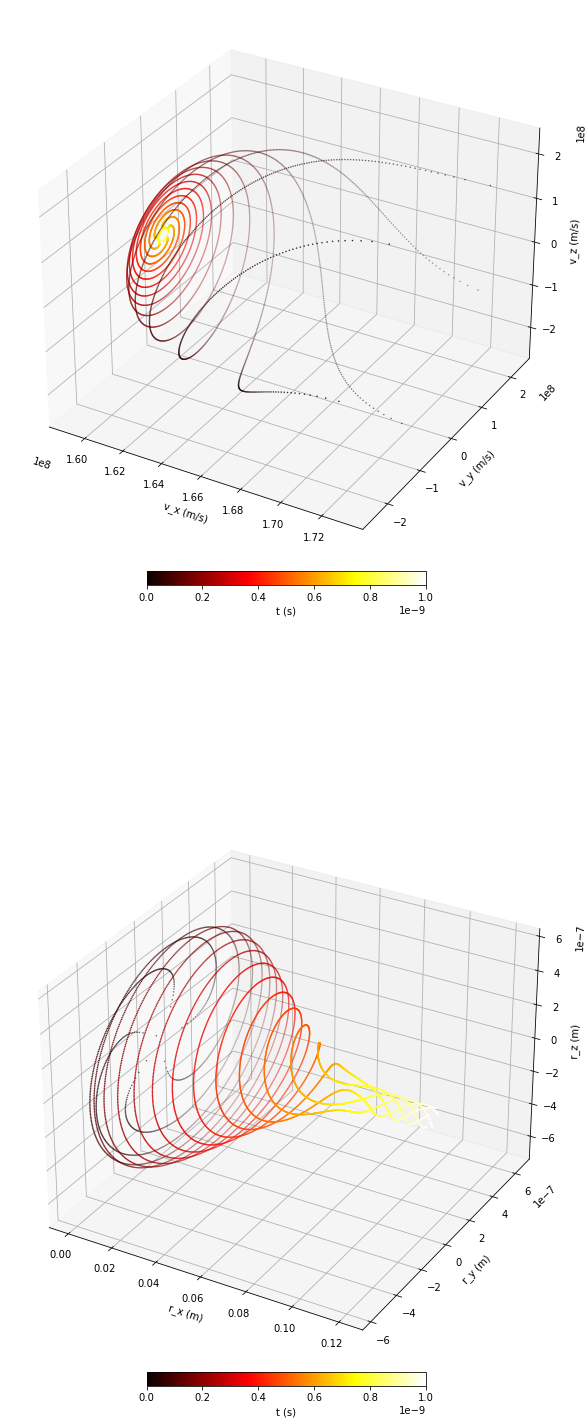

In [656]:
fig, axs = plt.subplots(2, 1, figsize=(10, 27), subplot_kw=dict(projection="3d"))
plot3D(axs[0], v, t, "v_", " (m/s)")
plot3D(axs[1], r, t, "r_", " (m)")

Text(0.5, 0, 't (s)')

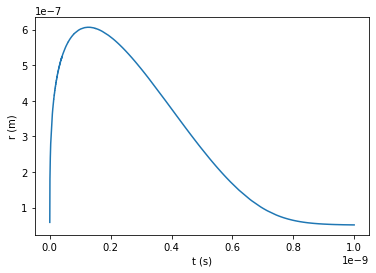

In [593]:
plt.plot(t, np.linalg.norm(r_corr[1:], axis=0))
plt.ylabel("r (m)")
plt.xlabel("t (s)")

Text(0.5, 0, 't (s)')

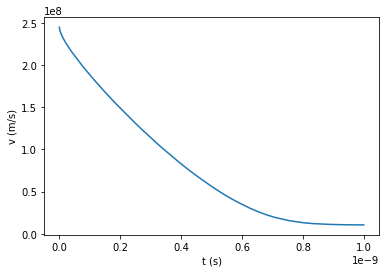

In [669]:
plt.plot(t, np.linalg.norm(v[1:], axis=0))
plt.ylabel("v (m/s)")
plt.xlabel("t (s)")

Text(0.5, 0, 't (s)')

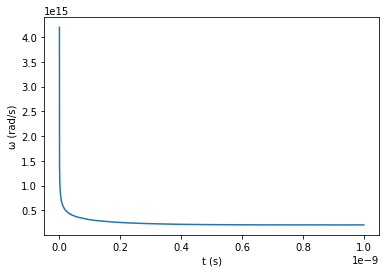

In [670]:
plt.plot(t, np.linalg.norm(v_corr[1:], axis=0)/np.linalg.norm(r_corr[1:], axis=0))
plt.ylabel("ω (rad/s)")
plt.xlabel("t (s)")

Text(0.5, 0, 't (s)')

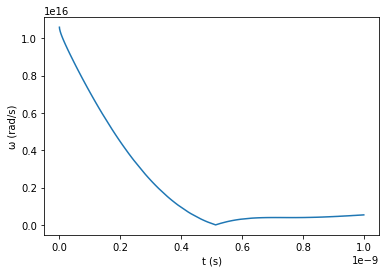

In [674]:
plt.plot(t, np.linalg.norm(omega, axis=0))
plt.ylabel("ω (rad/s)")
plt.xlabel("t (s)")

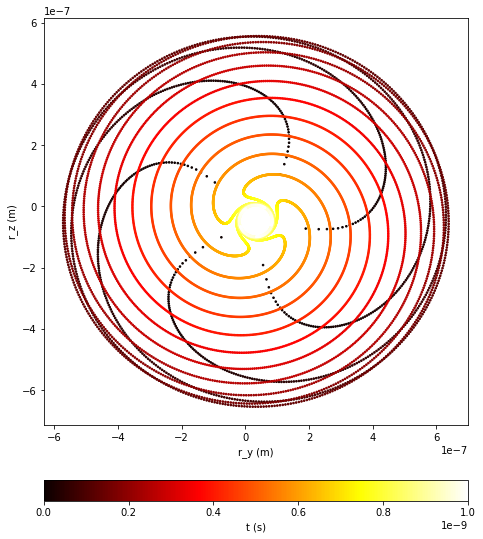

In [672]:
plt.figure(figsize=(7.6,10))
plt.scatter(*r[1:], marker=".", c=t, cmap="hot", s=10)
plt.xlabel("r_y (m)")
plt.ylabel("r_z (m)")
plt.colorbar(location="bottom", pad=0.1, label="t (s)")

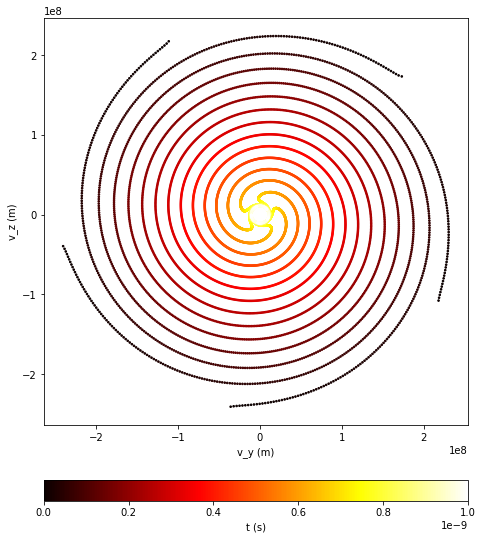

In [695]:
plt.figure(figsize=(7.6,10))
plt.scatter(*v[1:], marker=".", c=t, cmap="hot", s=10)
plt.xlabel("v_y (m)")
plt.ylabel("v_z (m)")
plt.colorbar(location="bottom", pad=0.1, label="t (s)")